# Solve the forward pass when u flutuates quite fast


# Libraries

In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation


In [2]:
def plot_car_trajectory(simulator,sampling_freq):
    fig,ax = plt.subplots(2,3, figsize=(12, 9))
    
    states_sim = simulator.data['_x'][::sampling_freq]
    time =  simulator.data['_time'][::sampling_freq]
    friction = simulator.data['_tvp'][::sampling_freq,0]
    wind = simulator.data['_tvp'][::sampling_freq,1]
    force = simulator.data['_u'][::sampling_freq]
    
    ax[0,0].plot(time,states_sim[:,1]*3.6)
    ax[0,0].set_xlabel("Time")
    ax[0,0].set_ylabel("Velocity (km/hr)")    
    
    dist = states_sim[:,0]/1000
    ax[0,1].plot(time,dist)
    ax[0,1].set_xlabel("Time")
    ax[0,1].set_ylabel("Distance (km)")     
    ax[1,0].plot(time,friction*(1-exp(-states_sim[:,1])),label = "Rolling")
    

    ax[1,0].plot(time,k1*states_sim[:,1]**2,label = "Aero")
    ax[1,0].plot(time,wind,label = "Wind")
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Drag Components")    
    ax[1,0].legend(loc="upper right")
    
    ax[1,1].plot(time,force)
    ax[1,1].set_xlabel("Time")
    ax[1,1].set_ylabel("Acceleration input")     
    
    total_fuel_burn = np.cumsum(a_0 + a_1*force)/1000
    ax[0,2].plot(time,total_fuel_burn)
    ax[0,2].set_xlabel("Time")
    ax[0,2].set_ylabel("Total Fuel Burn (klitres)")     
    instaneous_milage = (total_fuel_burn[1:] - total_fuel_burn[0:-1]) / (dist[1:] - dist[0:-1])

    ax[1,2].plot(time[1:],instaneous_milage)
    ax[1,2].set_xlabel("Time (secs)")
    ax[1,2].set_ylabel("Instaneous Milage (klitres/km)")     

In [3]:
# Defining the constants

a_0 = 0 # assume that fuel burn and force are 1-1 correlated
a_1 = 1
m = 500 # kg # car is half a ton
k1 = 50/450

model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))

k0 = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
fw = model.set_variable(var_type='_tvp', var_name='wind', shape=(1, 1))
acc = model.set_variable(var_type='_u', var_name='acc', shape=(1,1))

x_next = vertcat(x[1], acc/m - (k0*(1-exp(-x[1])) + k1*x[1]**2)/m - fw/m)
model.set_rhs('x',x_next)
model.setup()

params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    tvp_template['wind'] = 0*np.random.normal(0,10)
    if t_now < 200:
        tvp_template['friction'] = 50
    else:
        tvp_template['friction'] = 50    
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()

simulator.x0 = np.array([0,0])

In [4]:
v_s = np.sqrt(450)
best_u = 50*(1-np.exp(-v_s)) + 50/450*v_s**2

In [5]:
def expert_controller(simulator,target_vel):
    current_distance = simulator.data['_x'][-1,0]
    current_velocity = simulator.data['_x'][-1,1]
    current_force = simulator.data['_u'][-1]
    if current_velocity < target_vel and current_force == 0:
        u0 = (150 + 1)*np.ones((1,1))
    elif current_velocity < target_vel and current_force > 0:
        u0 = (current_force + 1)*np.ones((1,1))
    else:
        u0 = 0*np.ones((1,1))
    return u0

In [6]:
u0 = best_u*np.ones((1,1))
simulator.reset_history()
simulator.x0 = np.array([0,0])
for i in range(200):
    simulator.make_step(u0)
    u0 = expert_controller(simulator,v_s)

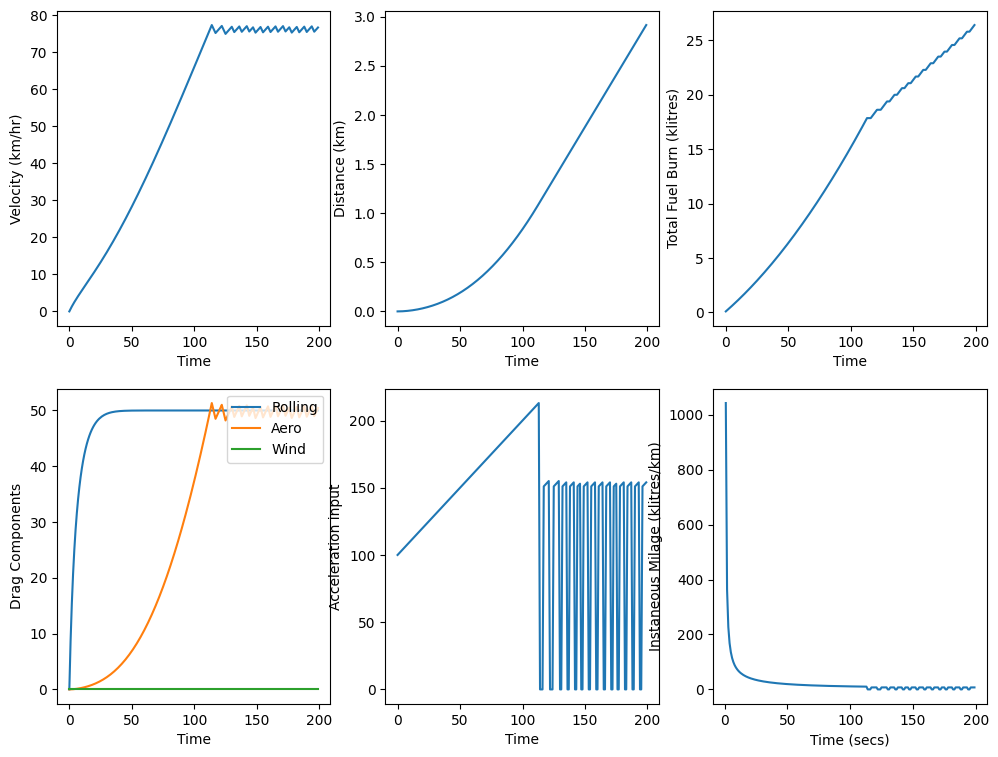

In [7]:
plot_car_trajectory(simulator,sampling_freq = 1)

In [8]:
#print the data
import pandas as pd
data = np.hstack((simulator.data['_time'], simulator.data['_x'],simulator.data['_u'],simulator.data['_tvp']))
df = pd.DataFrame(data, columns = ['time','displacement','velocity','force','friction_0','wind'])
df.to_csv('simple_car.csv')

# Now let's try to measure the friction

In [9]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam

In [10]:
class car_approx(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh(),l1_init = 0.1):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out


In [11]:
class Friction_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
Fapprox = Friction_approximator(2,3)

In [12]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [13]:
# Normalising constants
Mc = 500.0
Tc = len(simulator.data['_time'])
Vc = 80.0/3.6
Uc = 250.0


def calc_de_loss(nn,rr,t_col_n,un):
    #f(rr,t_col_n)
    de_loss = Mc*Vc/Tc*1*df(nn,t_col_n,1) - (Uc*un - (50*f(rr,t_col_n)*(1-torch.exp(-Vc*f(nn,t_col_n)))+ 50/450*f(nn,t_col_n)*f(nn,t_col_n)*Vc**2 ) ) 
    return de_loss

def calc_bc_loss(nn,rr,t_data_n,vn):
    bc_loss = Vc*(f(nn,t_data_n) - vn)
    return bc_loss

def compute_loss(nn,rr,t_col_n,t_data_n,data_n):
    un = data_n[:,2].view(-1,1)
    vn = data_n[:,1].view(-1,1)
    
    de_loss = calc_de_loss(nn,rr,t_col_n,un)
    bc_loss = calc_bc_loss(nn,rr,t_data_n,vn)

    final_loss = bc_loss.pow(2).mean() + de_loss.pow(2).mean()

    return final_loss,de_loss.pow(2).mean() ,bc_loss.pow(2).mean() 


def optimise(optimiser,nn,rr,t_col_n,t_data_n,data_n):
    optimiser.zero_grad()
    loss,de_loss,bc_loss = compute_loss(nn,rr,t_col_n,t_data_n,data_n)
    loss.backward()
    optimiser.step()
    return loss,de_loss,bc_loss

In [14]:
lr = 0.01
epochs = 10000
PINN = car_approx(3,20)
F_approx = Friction_approximator(2,4)
learnable_params = list(PINN.parameters()) + list(F_approx.parameters())
pi_optimizer = Adam(learnable_params, lr=lr)

In [15]:
t_interior = torch.from_numpy(simulator.data['_time']).float()[0:400]
sensor_data = torch.from_numpy(np.hstack((simulator.data['_x'],simulator.data['_u']))).float().div(torch.tensor([[1,Vc,Uc]]))[0:400]
t_interior = t_interior.clone()/Tc

t_collocation =  t_interior.clone()
t_collocation.requires_grad = True

In [16]:
sensor_data.max(0)

torch.return_types.max(
values=tensor([2.9150e+03, 9.6725e-01, 8.5200e-01]),
indices=tensor([199, 114, 113]))

In [17]:
max(t_collocation)

tensor([0.9950], grad_fn=<UnbindBackward0>)

In [18]:
max(t_interior)

tensor([0.9950])

In [19]:
torch.tensor([[1,Vc,Uc]]).size()

torch.Size([1, 3])

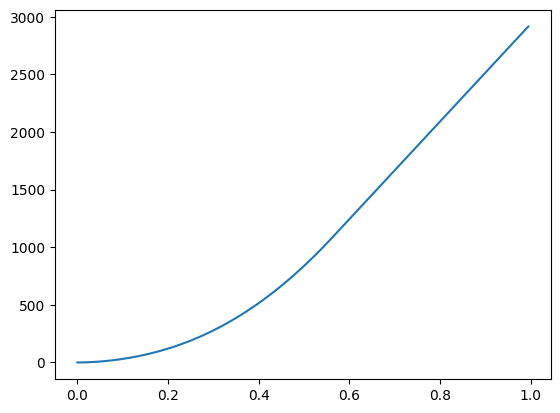

In [20]:
plt.figure()
plt.plot(t_interior,sensor_data[:,0])

In [21]:
#batch_size = 128
#loss_vector = []
#iteration_vector =[]
#for i in range(8000):
#    print(f"Epoch {i}")
#    permutation = torch.randperm(t_interior.size()[0])
#    for j in range(0,t_interior.size()[0],batch_size):
#        indices = permutation[j:j+batch_size]
#        loss,de_loss,bc_loss = optimise(pi_optimizer,PINN,F_approx,t_collocation[indices],t_interior[indices],sensor_data[indices])
#    iteration_vector.append(i)
#    loss_vector.append(loss.detach().numpy())
#    print(loss.detach().numpy(),de_loss.detach().numpy(),bc_loss.detach().numpy())

In [22]:
min_loss = 10**6

In [23]:
PATH = "model.pt"
pi_optimizer = Adam(learnable_params, lr=0.01)
full_loss_vector = []
de_loss_vector = []
bc_loss_vector = []
iteration_vector =[]
friction_prediction_vector = []
for i in range(1000000):
    loss,de_loss,bc_loss = optimise(pi_optimizer,PINN,F_approx,t_collocation,t_interior,sensor_data)
    if min_loss > loss.detach().numpy().item():
        min_loss = loss.detach().numpy().item()
        best_state_pinn = PINN.state_dict() 
        best_state_friction = F_approx.state_dict()
        print(f"New Optimal found at {i}. Best loss = {min_loss}")
    if i % 1000==0:
        iteration_vector.append(i)
        full_loss_vector.append(loss.detach().numpy())
        de_loss_vector.append(de_loss.detach().numpy())
        bc_loss_vector.append(bc_loss.detach().numpy())

        t_data_domain = torch.linspace(0, 200, steps=1000).view(-1, 1)
        with torch.no_grad():
            r_prediction = F_approx(t_data_domain).numpy()*50
        friction_prediction_vector.append(r_prediction.mean())
        
        print(i,loss.detach().numpy(),de_loss.detach().numpy(),bc_loss.detach().numpy(),r_prediction.mean())


0 5779175.5 5778822.5 353.12372 -34.20139
New Optimal found at 1. Best loss = 25799.234375
New Optimal found at 3. Best loss = 25315.74609375
New Optimal found at 4. Best loss = 24261.853515625
New Optimal found at 5. Best loss = 23222.44140625
New Optimal found at 6. Best loss = 22242.439453125
New Optimal found at 7. Best loss = 21337.837890625
New Optimal found at 8. Best loss = 20511.779296875
New Optimal found at 9. Best loss = 19761.498046875
New Optimal found at 10. Best loss = 19081.669921875
New Optimal found at 11. Best loss = 18466.052734375
New Optimal found at 12. Best loss = 17908.298828125
New Optimal found at 13. Best loss = 17402.36328125
New Optimal found at 14. Best loss = 16942.66796875
New Optimal found at 15. Best loss = 16524.158203125
New Optimal found at 16. Best loss = 16142.3095703125
New Optimal found at 17. Best loss = 15793.0947265625
New Optimal found at 18. Best loss = 15472.9404296875
New Optimal found at 19. Best loss = 15178.6787109375
New Optimal fou

New Optimal found at 160. Best loss = 5273.74853515625
New Optimal found at 161. Best loss = 5247.65380859375
New Optimal found at 162. Best loss = 5221.9970703125
New Optimal found at 163. Best loss = 5196.7763671875
New Optimal found at 164. Best loss = 5171.986328125
New Optimal found at 165. Best loss = 5147.62109375
New Optimal found at 166. Best loss = 5123.677734375
New Optimal found at 167. Best loss = 5100.1513671875
New Optimal found at 168. Best loss = 5077.03759765625
New Optimal found at 169. Best loss = 5054.33056640625
New Optimal found at 170. Best loss = 5032.02685546875
New Optimal found at 171. Best loss = 5010.12353515625
New Optimal found at 172. Best loss = 4988.61328125
New Optimal found at 173. Best loss = 4967.4921875
New Optimal found at 174. Best loss = 4946.7568359375
New Optimal found at 175. Best loss = 4926.40185546875
New Optimal found at 176. Best loss = 4906.421875
New Optimal found at 177. Best loss = 4886.81298828125
New Optimal found at 178. Best lo

New Optimal found at 321. Best loss = 4064.438232421875
New Optimal found at 322. Best loss = 4064.0556640625
New Optimal found at 323. Best loss = 4063.685546875
New Optimal found at 324. Best loss = 4063.32666015625
New Optimal found at 325. Best loss = 4062.980712890625
New Optimal found at 326. Best loss = 4062.645263671875
New Optimal found at 327. Best loss = 4062.32080078125
New Optimal found at 328. Best loss = 4062.007080078125
New Optimal found at 329. Best loss = 4061.702880859375
New Optimal found at 330. Best loss = 4061.40869140625
New Optimal found at 331. Best loss = 4061.1240234375
New Optimal found at 332. Best loss = 4060.848388671875
New Optimal found at 333. Best loss = 4060.58203125
New Optimal found at 334. Best loss = 4060.32373046875
New Optimal found at 335. Best loss = 4060.07373046875
New Optimal found at 336. Best loss = 4059.83203125
New Optimal found at 337. Best loss = 4059.596923828125
New Optimal found at 338. Best loss = 4059.3701171875
New Optimal fo

New Optimal found at 482. Best loss = 4048.990478515625
New Optimal found at 483. Best loss = 4048.9462890625
New Optimal found at 484. Best loss = 4048.90234375
New Optimal found at 485. Best loss = 4048.85888671875
New Optimal found at 486. Best loss = 4048.81396484375
New Optimal found at 487. Best loss = 4048.76953125
New Optimal found at 488. Best loss = 4048.72509765625
New Optimal found at 489. Best loss = 4048.68115234375
New Optimal found at 490. Best loss = 4048.637451171875
New Optimal found at 491. Best loss = 4048.592529296875
New Optimal found at 492. Best loss = 4048.547607421875
New Optimal found at 493. Best loss = 4048.50341796875
New Optimal found at 494. Best loss = 4048.458740234375
New Optimal found at 495. Best loss = 4048.414306640625
New Optimal found at 496. Best loss = 4048.369873046875
New Optimal found at 497. Best loss = 4048.325439453125
New Optimal found at 498. Best loss = 4048.2802734375
New Optimal found at 499. Best loss = 4048.23583984375
New Optima

New Optimal found at 652. Best loss = 4040.982177734375
New Optimal found at 653. Best loss = 4040.931884765625
New Optimal found at 654. Best loss = 4040.8818359375
New Optimal found at 655. Best loss = 4040.83203125
New Optimal found at 656. Best loss = 4040.782470703125
New Optimal found at 657. Best loss = 4040.73193359375
New Optimal found at 658. Best loss = 4040.682373046875
New Optimal found at 659. Best loss = 4040.631591796875
New Optimal found at 660. Best loss = 4040.58154296875
New Optimal found at 661. Best loss = 4040.53173828125
New Optimal found at 662. Best loss = 4040.4814453125
New Optimal found at 663. Best loss = 4040.431640625
New Optimal found at 664. Best loss = 4040.3818359375
New Optimal found at 665. Best loss = 4040.330810546875
New Optimal found at 666. Best loss = 4040.28076171875
New Optimal found at 667. Best loss = 4040.230224609375
New Optimal found at 668. Best loss = 4040.1796875
New Optimal found at 669. Best loss = 4040.12939453125
New Optimal fou

New Optimal found at 824. Best loss = 4032.039306640625
New Optimal found at 825. Best loss = 4031.98583984375
New Optimal found at 826. Best loss = 4031.931640625
New Optimal found at 827. Best loss = 4031.87841796875
New Optimal found at 828. Best loss = 4031.824462890625
New Optimal found at 829. Best loss = 4031.7705078125
New Optimal found at 830. Best loss = 4031.717041015625
New Optimal found at 831. Best loss = 4031.6630859375
New Optimal found at 832. Best loss = 4031.60888671875
New Optimal found at 833. Best loss = 4031.555419921875
New Optimal found at 834. Best loss = 4031.5009765625
New Optimal found at 835. Best loss = 4031.44775390625
New Optimal found at 836. Best loss = 4031.3935546875
New Optimal found at 837. Best loss = 4031.33935546875
New Optimal found at 838. Best loss = 4031.28564453125
New Optimal found at 839. Best loss = 4031.2314453125
New Optimal found at 840. Best loss = 4031.177978515625
New Optimal found at 841. Best loss = 4031.123779296875
New Optimal

New Optimal found at 993. Best loss = 4022.787109375
New Optimal found at 994. Best loss = 4022.731689453125
New Optimal found at 995. Best loss = 4022.67626953125
New Optimal found at 996. Best loss = 4022.620849609375
New Optimal found at 997. Best loss = 4022.565673828125
New Optimal found at 998. Best loss = 4022.510009765625
New Optimal found at 999. Best loss = 4022.4541015625
New Optimal found at 1000. Best loss = 4022.39892578125
1000 4022.399 3514.055 508.34387 -22.362446
New Optimal found at 1001. Best loss = 4022.34326171875
New Optimal found at 1002. Best loss = 4022.288330078125
New Optimal found at 1003. Best loss = 4022.232666015625
New Optimal found at 1004. Best loss = 4022.17724609375
New Optimal found at 1005. Best loss = 4022.121337890625
New Optimal found at 1006. Best loss = 4022.06591796875
New Optimal found at 1007. Best loss = 4022.010498046875
New Optimal found at 1008. Best loss = 4021.954833984375
New Optimal found at 1009. Best loss = 4021.8994140625
New Op

New Optimal found at 1148. Best loss = 4014.177001953125
New Optimal found at 1149. Best loss = 4014.12158203125
New Optimal found at 1150. Best loss = 4014.06640625
New Optimal found at 1151. Best loss = 4014.010986328125
New Optimal found at 1152. Best loss = 4013.955322265625
New Optimal found at 1153. Best loss = 4013.89990234375
New Optimal found at 1154. Best loss = 4013.844482421875
New Optimal found at 1155. Best loss = 4013.789306640625
New Optimal found at 1156. Best loss = 4013.733642578125
New Optimal found at 1157. Best loss = 4013.67822265625
New Optimal found at 1158. Best loss = 4013.622314453125
New Optimal found at 1159. Best loss = 4013.5673828125
New Optimal found at 1160. Best loss = 4013.51123046875
New Optimal found at 1161. Best loss = 4013.45654296875
New Optimal found at 1162. Best loss = 4013.401123046875
New Optimal found at 1163. Best loss = 4013.345947265625
New Optimal found at 1164. Best loss = 4013.290283203125
New Optimal found at 1165. Best loss = 401

New Optimal found at 1307. Best loss = 4005.434814453125
New Optimal found at 1308. Best loss = 4005.38037109375
New Optimal found at 1309. Best loss = 4005.326171875
New Optimal found at 1310. Best loss = 4005.272216796875
New Optimal found at 1311. Best loss = 4005.21728515625
New Optimal found at 1312. Best loss = 4005.16259765625
New Optimal found at 1313. Best loss = 4005.10888671875
New Optimal found at 1314. Best loss = 4005.053955078125
New Optimal found at 1315. Best loss = 4004.99951171875
New Optimal found at 1316. Best loss = 4004.94580078125
New Optimal found at 1317. Best loss = 4004.8916015625
New Optimal found at 1318. Best loss = 4004.837158203125
New Optimal found at 1319. Best loss = 4004.782470703125
New Optimal found at 1320. Best loss = 4004.728515625
New Optimal found at 1321. Best loss = 4004.67431640625
New Optimal found at 1322. Best loss = 4004.61962890625
New Optimal found at 1323. Best loss = 4004.565673828125
New Optimal found at 1324. Best loss = 4004.511

New Optimal found at 1469. Best loss = 3996.730224609375
New Optimal found at 1470. Best loss = 3996.67724609375
New Optimal found at 1471. Best loss = 3996.624267578125
New Optimal found at 1472. Best loss = 3996.5712890625
New Optimal found at 1473. Best loss = 3996.517578125
New Optimal found at 1474. Best loss = 3996.46435546875
New Optimal found at 1475. Best loss = 3996.41162109375
New Optimal found at 1476. Best loss = 3996.3583984375
New Optimal found at 1477. Best loss = 3996.3056640625
New Optimal found at 1478. Best loss = 3996.25244140625
New Optimal found at 1479. Best loss = 3996.198974609375
New Optimal found at 1480. Best loss = 3996.146240234375
New Optimal found at 1481. Best loss = 3996.093505859375
New Optimal found at 1482. Best loss = 3996.040283203125
New Optimal found at 1483. Best loss = 3995.98681640625
New Optimal found at 1484. Best loss = 3995.933837890625
New Optimal found at 1485. Best loss = 3995.880859375
New Optimal found at 1486. Best loss = 3995.8276

New Optimal found at 1638. Best loss = 3987.80859375
New Optimal found at 1639. Best loss = 3987.755126953125
New Optimal found at 1640. Best loss = 3987.703125
New Optimal found at 1641. Best loss = 3987.650146484375
New Optimal found at 1642. Best loss = 3987.597900390625
New Optimal found at 1643. Best loss = 3987.54443359375
New Optimal found at 1644. Best loss = 3987.4921875
New Optimal found at 1645. Best loss = 3987.439208984375
New Optimal found at 1646. Best loss = 3987.38623046875
New Optimal found at 1647. Best loss = 3987.333251953125
New Optimal found at 1648. Best loss = 3987.281005859375
New Optimal found at 1649. Best loss = 3987.228271484375
New Optimal found at 1650. Best loss = 3987.17529296875
New Optimal found at 1651. Best loss = 3987.1220703125
New Optimal found at 1652. Best loss = 3987.06982421875
New Optimal found at 1653. Best loss = 3987.01708984375
New Optimal found at 1654. Best loss = 3986.964111328125
New Optimal found at 1655. Best loss = 3986.911132812

New Optimal found at 1803. Best loss = 3978.98974609375
New Optimal found at 1804. Best loss = 3978.934814453125
New Optimal found at 1805. Best loss = 3978.880126953125
New Optimal found at 1806. Best loss = 3978.82568359375
New Optimal found at 1807. Best loss = 3978.770751953125
New Optimal found at 1808. Best loss = 3978.716064453125
New Optimal found at 1809. Best loss = 3978.66162109375
New Optimal found at 1810. Best loss = 3978.606689453125
New Optimal found at 1811. Best loss = 3978.5517578125
New Optimal found at 1812. Best loss = 3978.49658203125
New Optimal found at 1813. Best loss = 3978.4423828125
New Optimal found at 1814. Best loss = 3978.38671875
New Optimal found at 1815. Best loss = 3978.33154296875
New Optimal found at 1816. Best loss = 3978.27734375
New Optimal found at 1817. Best loss = 3978.22265625
New Optimal found at 1818. Best loss = 3978.16796875
New Optimal found at 1819. Best loss = 3978.112548828125
New Optimal found at 1820. Best loss = 3978.05810546875


New Optimal found at 1957. Best loss = 3970.248291015625
New Optimal found at 1958. Best loss = 3970.18896484375
New Optimal found at 1959. Best loss = 3970.12939453125
New Optimal found at 1960. Best loss = 3970.0693359375
New Optimal found at 1961. Best loss = 3970.009765625
New Optimal found at 1962. Best loss = 3969.9501953125
New Optimal found at 1963. Best loss = 3969.890625
New Optimal found at 1964. Best loss = 3969.83056640625
New Optimal found at 1965. Best loss = 3969.77099609375
New Optimal found at 1966. Best loss = 3969.71142578125
New Optimal found at 1967. Best loss = 3969.65087890625
New Optimal found at 1968. Best loss = 3969.5908203125
New Optimal found at 1969. Best loss = 3969.531005859375
New Optimal found at 1970. Best loss = 3969.47119140625
New Optimal found at 1971. Best loss = 3969.4111328125
New Optimal found at 1972. Best loss = 3969.3505859375
New Optimal found at 1973. Best loss = 3969.291015625
New Optimal found at 1974. Best loss = 3969.230224609375
New

New Optimal found at 2109. Best loss = 3960.592529296875
New Optimal found at 2110. Best loss = 3960.5244140625
New Optimal found at 2111. Best loss = 3960.455810546875
New Optimal found at 2112. Best loss = 3960.386962890625
New Optimal found at 2113. Best loss = 3960.318359375
New Optimal found at 2114. Best loss = 3960.24951171875
New Optimal found at 2115. Best loss = 3960.18115234375
New Optimal found at 2116. Best loss = 3960.1123046875
New Optimal found at 2117. Best loss = 3960.04296875
New Optimal found at 2118. Best loss = 3959.974365234375
New Optimal found at 2119. Best loss = 3959.9052734375
New Optimal found at 2120. Best loss = 3959.8359375
New Optimal found at 2121. Best loss = 3959.766845703125
New Optimal found at 2122. Best loss = 3959.697509765625
New Optimal found at 2123. Best loss = 3959.6279296875
New Optimal found at 2124. Best loss = 3959.55859375
New Optimal found at 2125. Best loss = 3959.4892578125
New Optimal found at 2126. Best loss = 3959.4189453125
New 

New Optimal found at 2264. Best loss = 3948.9228515625
New Optimal found at 2265. Best loss = 3948.839111328125
New Optimal found at 2266. Best loss = 3948.75537109375
New Optimal found at 2267. Best loss = 3948.671630859375
New Optimal found at 2268. Best loss = 3948.587890625
New Optimal found at 2269. Best loss = 3948.503662109375
New Optimal found at 2270. Best loss = 3948.419189453125
New Optimal found at 2271. Best loss = 3948.33544921875
New Optimal found at 2272. Best loss = 3948.2509765625
New Optimal found at 2273. Best loss = 3948.166015625
New Optimal found at 2274. Best loss = 3948.081787109375
New Optimal found at 2275. Best loss = 3947.996826171875
New Optimal found at 2276. Best loss = 3947.912109375
New Optimal found at 2277. Best loss = 3947.826904296875
New Optimal found at 2278. Best loss = 3947.74169921875
New Optimal found at 2279. Best loss = 3947.656494140625
New Optimal found at 2280. Best loss = 3947.5712890625
New Optimal found at 2281. Best loss = 3947.48510

New Optimal found at 2425. Best loss = 3933.5546875
New Optimal found at 2426. Best loss = 3933.444580078125
New Optimal found at 2427. Best loss = 3933.335205078125
New Optimal found at 2428. Best loss = 3933.224609375
New Optimal found at 2429. Best loss = 3933.1142578125
New Optimal found at 2430. Best loss = 3933.00341796875
New Optimal found at 2431. Best loss = 3932.892578125
New Optimal found at 2432. Best loss = 3932.78173828125
New Optimal found at 2433. Best loss = 3932.669921875
New Optimal found at 2434. Best loss = 3932.55810546875
New Optimal found at 2435. Best loss = 3932.4462890625
New Optimal found at 2436. Best loss = 3932.33544921875
New Optimal found at 2437. Best loss = 3932.222412109375
New Optimal found at 2438. Best loss = 3932.10986328125
New Optimal found at 2439. Best loss = 3931.99755859375
New Optimal found at 2440. Best loss = 3931.884765625
New Optimal found at 2441. Best loss = 3931.771728515625
New Optimal found at 2442. Best loss = 3931.658447265625
N

New Optimal found at 2592. Best loss = 3911.65576171875
New Optimal found at 2593. Best loss = 3911.49853515625
New Optimal found at 2594. Best loss = 3911.34033203125
New Optimal found at 2595. Best loss = 3911.182373046875
New Optimal found at 2596. Best loss = 3911.024169921875
New Optimal found at 2597. Best loss = 3910.86474609375
New Optimal found at 2598. Best loss = 3910.7060546875
New Optimal found at 2599. Best loss = 3910.546630859375
New Optimal found at 2600. Best loss = 3910.386474609375
New Optimal found at 2601. Best loss = 3910.226806640625
New Optimal found at 2602. Best loss = 3910.06591796875
New Optimal found at 2603. Best loss = 3909.90478515625
New Optimal found at 2604. Best loss = 3909.74267578125
New Optimal found at 2605. Best loss = 3909.581298828125
New Optimal found at 2606. Best loss = 3909.419189453125
New Optimal found at 2607. Best loss = 3909.256103515625
New Optimal found at 2608. Best loss = 3909.093505859375
New Optimal found at 2609. Best loss = 3

New Optimal found at 2750. Best loss = 3880.870849609375
New Optimal found at 2751. Best loss = 3880.626953125
New Optimal found at 2752. Best loss = 3880.3818359375
New Optimal found at 2753. Best loss = 3880.135986328125
New Optimal found at 2754. Best loss = 3879.88916015625
New Optimal found at 2755. Best loss = 3879.641845703125
New Optimal found at 2756. Best loss = 3879.3935546875
New Optimal found at 2757. Best loss = 3879.14404296875
New Optimal found at 2758. Best loss = 3878.894775390625
New Optimal found at 2759. Best loss = 3878.643798828125
New Optimal found at 2760. Best loss = 3878.392333984375
New Optimal found at 2761. Best loss = 3878.139404296875
New Optimal found at 2762. Best loss = 3877.88623046875
New Optimal found at 2763. Best loss = 3877.63232421875
New Optimal found at 2764. Best loss = 3877.37646484375
New Optimal found at 2765. Best loss = 3877.120849609375
New Optimal found at 2766. Best loss = 3876.86376953125
New Optimal found at 2767. Best loss = 3876.

New Optimal found at 2916. Best loss = 3823.192626953125
New Optimal found at 2917. Best loss = 3822.685546875
New Optimal found at 2918. Best loss = 3822.175048828125
New Optimal found at 2919. Best loss = 3821.661865234375
New Optimal found at 2920. Best loss = 3821.145263671875
New Optimal found at 2921. Best loss = 3820.626220703125
New Optimal found at 2922. Best loss = 3820.103759765625
New Optimal found at 2923. Best loss = 3819.579345703125
New Optimal found at 2924. Best loss = 3819.05078125
New Optimal found at 2925. Best loss = 3818.519287109375
New Optimal found at 2926. Best loss = 3817.98486328125
New Optimal found at 2927. Best loss = 3817.447509765625
New Optimal found at 2928. Best loss = 3816.90625
New Optimal found at 2929. Best loss = 3816.36181640625
New Optimal found at 2930. Best loss = 3815.81494140625
New Optimal found at 2931. Best loss = 3815.264404296875
New Optimal found at 2932. Best loss = 3814.71044921875
New Optimal found at 2933. Best loss = 3814.15307

New Optimal found at 3077. Best loss = 3678.41845703125
New Optimal found at 3078. Best loss = 3676.915283203125
New Optimal found at 3079. Best loss = 3675.402099609375
New Optimal found at 3080. Best loss = 3673.87841796875
New Optimal found at 3081. Best loss = 3672.344482421875
New Optimal found at 3082. Best loss = 3670.800537109375
New Optimal found at 3083. Best loss = 3669.24609375
New Optimal found at 3084. Best loss = 3667.681640625
New Optimal found at 3085. Best loss = 3666.106689453125
New Optimal found at 3086. Best loss = 3664.521240234375
New Optimal found at 3087. Best loss = 3662.92529296875
New Optimal found at 3088. Best loss = 3661.3193359375
New Optimal found at 3089. Best loss = 3659.702392578125
New Optimal found at 3090. Best loss = 3658.0751953125
New Optimal found at 3091. Best loss = 3656.43798828125
New Optimal found at 3092. Best loss = 3654.7900390625
New Optimal found at 3093. Best loss = 3653.130859375
New Optimal found at 3094. Best loss = 3651.4614257

New Optimal found at 3238. Best loss = 3340.11279296875
New Optimal found at 3239. Best loss = 3338.04345703125
New Optimal found at 3240. Best loss = 3335.984619140625
New Optimal found at 3241. Best loss = 3333.937255859375
New Optimal found at 3242. Best loss = 3331.90185546875
New Optimal found at 3243. Best loss = 3329.878173828125
New Optimal found at 3244. Best loss = 3327.8662109375
New Optimal found at 3245. Best loss = 3325.8662109375
New Optimal found at 3246. Best loss = 3323.8779296875
New Optimal found at 3247. Best loss = 3321.902587890625
New Optimal found at 3248. Best loss = 3319.9384765625
New Optimal found at 3249. Best loss = 3317.987060546875
New Optimal found at 3250. Best loss = 3316.04931640625
New Optimal found at 3251. Best loss = 3314.123779296875
New Optimal found at 3252. Best loss = 3312.2109375
New Optimal found at 3253. Best loss = 3310.31103515625
New Optimal found at 3254. Best loss = 3308.423583984375
New Optimal found at 3255. Best loss = 3306.55004

New Optimal found at 3407. Best loss = 3158.84423828125
New Optimal found at 3408. Best loss = 3158.432861328125
New Optimal found at 3409. Best loss = 3158.02392578125
New Optimal found at 3410. Best loss = 3157.6171875
New Optimal found at 3411. Best loss = 3157.21240234375
New Optimal found at 3412. Best loss = 3156.810546875
New Optimal found at 3413. Best loss = 3156.410400390625
New Optimal found at 3414. Best loss = 3156.012939453125
New Optimal found at 3415. Best loss = 3155.61767578125
New Optimal found at 3416. Best loss = 3155.223876953125
New Optimal found at 3417. Best loss = 3154.8330078125
New Optimal found at 3418. Best loss = 3154.443603515625
New Optimal found at 3419. Best loss = 3154.0556640625
New Optimal found at 3420. Best loss = 3153.669921875
New Optimal found at 3421. Best loss = 3153.2861328125
New Optimal found at 3422. Best loss = 3152.90380859375
New Optimal found at 3423. Best loss = 3152.523193359375
New Optimal found at 3424. Best loss = 3152.144775390

New Optimal found at 3575. Best loss = 3097.152587890625
New Optimal found at 3576. Best loss = 3096.74609375
New Optimal found at 3577. Best loss = 3096.3388671875
New Optimal found at 3578. Best loss = 3095.93017578125
New Optimal found at 3579. Best loss = 3095.521240234375
New Optimal found at 3580. Best loss = 3095.111328125
New Optimal found at 3581. Best loss = 3094.699951171875
New Optimal found at 3582. Best loss = 3094.288330078125
New Optimal found at 3583. Best loss = 3093.875
New Optimal found at 3584. Best loss = 3093.46142578125
New Optimal found at 3585. Best loss = 3093.04638671875
New Optimal found at 3586. Best loss = 3092.63037109375
New Optimal found at 3587. Best loss = 3092.213623046875
New Optimal found at 3588. Best loss = 3091.796142578125
New Optimal found at 3589. Best loss = 3091.377197265625
New Optimal found at 3590. Best loss = 3090.9580078125
New Optimal found at 3591. Best loss = 3090.537353515625
New Optimal found at 3592. Best loss = 3090.1162109375


New Optimal found at 3746. Best loss = 3014.34716796875
New Optimal found at 3747. Best loss = 3013.7998046875
New Optimal found at 3748. Best loss = 3013.251220703125
New Optimal found at 3749. Best loss = 3012.703125
New Optimal found at 3750. Best loss = 3012.154052734375
New Optimal found at 3751. Best loss = 3011.6044921875
New Optimal found at 3752. Best loss = 3011.05517578125
New Optimal found at 3753. Best loss = 3010.5048828125
New Optimal found at 3754. Best loss = 3009.954345703125
New Optimal found at 3755. Best loss = 3009.403564453125
New Optimal found at 3756. Best loss = 3008.85205078125
New Optimal found at 3757. Best loss = 3008.30126953125
New Optimal found at 3758. Best loss = 3007.74853515625
New Optimal found at 3759. Best loss = 3007.19677734375
New Optimal found at 3760. Best loss = 3006.64453125
New Optimal found at 3761. Best loss = 3006.091796875
New Optimal found at 3762. Best loss = 3005.5380859375
New Optimal found at 3763. Best loss = 3004.985107421875
N

New Optimal found at 3908. Best loss = 2925.848388671875
New Optimal found at 3909. Best loss = 2925.337158203125
New Optimal found at 3910. Best loss = 2924.826171875
New Optimal found at 3911. Best loss = 2924.316650390625
New Optimal found at 3912. Best loss = 2923.807373046875
New Optimal found at 3913. Best loss = 2923.29931640625
New Optimal found at 3914. Best loss = 2922.79150390625
New Optimal found at 3915. Best loss = 2922.284912109375
New Optimal found at 3916. Best loss = 2921.778564453125
New Optimal found at 3917. Best loss = 2921.273681640625
New Optimal found at 3918. Best loss = 2920.76953125
New Optimal found at 3919. Best loss = 2920.265869140625
New Optimal found at 3920. Best loss = 2919.763671875
New Optimal found at 3921. Best loss = 2919.261474609375
New Optimal found at 3922. Best loss = 2918.7607421875
New Optimal found at 3923. Best loss = 2918.2607421875
New Optimal found at 3924. Best loss = 2917.76123046875
New Optimal found at 3925. Best loss = 2917.2624

New Optimal found at 4063. Best loss = 2857.15087890625
New Optimal found at 4064. Best loss = 2856.777099609375
New Optimal found at 4065. Best loss = 2856.404296875
New Optimal found at 4066. Best loss = 2856.031982421875
New Optimal found at 4067. Best loss = 2855.660888671875
New Optimal found at 4068. Best loss = 2855.290283203125
New Optimal found at 4069. Best loss = 2854.92041015625
New Optimal found at 4070. Best loss = 2854.552001953125
New Optimal found at 4071. Best loss = 2854.18359375
New Optimal found at 4072. Best loss = 2853.81640625
New Optimal found at 4073. Best loss = 2853.449951171875
New Optimal found at 4074. Best loss = 2853.08447265625
New Optimal found at 4075. Best loss = 2852.718994140625
New Optimal found at 4076. Best loss = 2852.355224609375
New Optimal found at 4077. Best loss = 2851.99169921875
New Optimal found at 4078. Best loss = 2851.629150390625
New Optimal found at 4079. Best loss = 2851.2666015625
New Optimal found at 4080. Best loss = 2850.9057

New Optimal found at 4232. Best loss = 2802.697021484375
New Optimal found at 4233. Best loss = 2802.410400390625
New Optimal found at 4234. Best loss = 2802.1240234375
New Optimal found at 4235. Best loss = 2801.83740234375
New Optimal found at 4236. Best loss = 2801.55126953125
New Optimal found at 4237. Best loss = 2801.265380859375
New Optimal found at 4238. Best loss = 2800.979736328125
New Optimal found at 4239. Best loss = 2800.6943359375
New Optimal found at 4240. Best loss = 2800.4091796875
New Optimal found at 4241. Best loss = 2800.1240234375
New Optimal found at 4242. Best loss = 2799.83935546875
New Optimal found at 4243. Best loss = 2799.554443359375
New Optimal found at 4244. Best loss = 2799.27001953125
New Optimal found at 4245. Best loss = 2798.986083984375
New Optimal found at 4246. Best loss = 2798.7021484375
New Optimal found at 4247. Best loss = 2798.418212890625
New Optimal found at 4248. Best loss = 2798.13427734375
New Optimal found at 4249. Best loss = 2797.85

New Optimal found at 4393. Best loss = 2757.894287109375
New Optimal found at 4394. Best loss = 2757.61572265625
New Optimal found at 4395. Best loss = 2757.337646484375
New Optimal found at 4396. Best loss = 2757.058837890625
New Optimal found at 4397. Best loss = 2756.77978515625
New Optimal found at 4398. Best loss = 2756.50146484375
New Optimal found at 4399. Best loss = 2756.22216796875
New Optimal found at 4400. Best loss = 2755.943115234375
New Optimal found at 4401. Best loss = 2755.6640625
New Optimal found at 4402. Best loss = 2755.385009765625
New Optimal found at 4403. Best loss = 2755.105712890625
New Optimal found at 4404. Best loss = 2754.825927734375
New Optimal found at 4405. Best loss = 2754.546142578125
New Optimal found at 4406. Best loss = 2754.266845703125
New Optimal found at 4407. Best loss = 2753.98681640625
New Optimal found at 4408. Best loss = 2753.70703125
New Optimal found at 4409. Best loss = 2753.427001953125
New Optimal found at 4410. Best loss = 2753.1

New Optimal found at 4561. Best loss = 2708.814453125
New Optimal found at 4562. Best loss = 2708.50537109375
New Optimal found at 4563. Best loss = 2708.196044921875
New Optimal found at 4564. Best loss = 2707.886474609375
New Optimal found at 4565. Best loss = 2707.57666015625
New Optimal found at 4566. Best loss = 2707.2666015625
New Optimal found at 4567. Best loss = 2706.95654296875
New Optimal found at 4568. Best loss = 2706.64599609375
New Optimal found at 4569. Best loss = 2706.33544921875
New Optimal found at 4570. Best loss = 2706.024169921875
New Optimal found at 4571. Best loss = 2705.713623046875
New Optimal found at 4572. Best loss = 2705.402099609375
New Optimal found at 4573. Best loss = 2705.091064453125
New Optimal found at 4574. Best loss = 2704.779296875
New Optimal found at 4575. Best loss = 2704.467529296875
New Optimal found at 4576. Best loss = 2704.15576171875
New Optimal found at 4577. Best loss = 2703.843505859375
New Optimal found at 4578. Best loss = 2703.5

New Optimal found at 4727. Best loss = 2655.60498046875
New Optimal found at 4728. Best loss = 2655.28076171875
New Optimal found at 4729. Best loss = 2654.95703125
New Optimal found at 4730. Best loss = 2654.63330078125
New Optimal found at 4731. Best loss = 2654.3095703125
New Optimal found at 4732. Best loss = 2653.986572265625
New Optimal found at 4733. Best loss = 2653.662841796875
New Optimal found at 4734. Best loss = 2653.340087890625
New Optimal found at 4735. Best loss = 2653.0166015625
New Optimal found at 4736. Best loss = 2652.693359375
New Optimal found at 4737. Best loss = 2652.37060546875
New Optimal found at 4738. Best loss = 2652.048095703125
New Optimal found at 4739. Best loss = 2651.725830078125
New Optimal found at 4740. Best loss = 2651.4033203125
New Optimal found at 4741. Best loss = 2651.0810546875
New Optimal found at 4742. Best loss = 2650.7587890625
New Optimal found at 4743. Best loss = 2650.436767578125
New Optimal found at 4744. Best loss = 2650.11474609

New Optimal found at 4895. Best loss = 2606.8447265625
New Optimal found at 4896. Best loss = 2606.620361328125
New Optimal found at 4897. Best loss = 2606.396484375
New Optimal found at 4898. Best loss = 2606.17431640625
New Optimal found at 4899. Best loss = 2605.95361328125
New Optimal found at 4900. Best loss = 2605.733154296875
New Optimal found at 4901. Best loss = 2605.514404296875
New Optimal found at 4902. Best loss = 2605.29638671875
New Optimal found at 4903. Best loss = 2605.079345703125
New Optimal found at 4904. Best loss = 2604.86376953125
New Optimal found at 4905. Best loss = 2604.64892578125
New Optimal found at 4906. Best loss = 2604.435546875
New Optimal found at 4907. Best loss = 2604.22314453125
New Optimal found at 4908. Best loss = 2604.01171875
New Optimal found at 4909. Best loss = 2603.801513671875
New Optimal found at 4910. Best loss = 2603.59228515625
New Optimal found at 4911. Best loss = 2603.384033203125
New Optimal found at 4912. Best loss = 2603.177001

New Optimal found at 5056. Best loss = 2581.35205078125
New Optimal found at 5057. Best loss = 2581.235107421875
New Optimal found at 5058. Best loss = 2581.1181640625
New Optimal found at 5059. Best loss = 2581.00146484375
New Optimal found at 5060. Best loss = 2580.885009765625
New Optimal found at 5061. Best loss = 2580.76904296875
New Optimal found at 5062. Best loss = 2580.65283203125
New Optimal found at 5063. Best loss = 2580.537109375
New Optimal found at 5064. Best loss = 2580.421875
New Optimal found at 5065. Best loss = 2580.306640625
New Optimal found at 5066. Best loss = 2580.191650390625
New Optimal found at 5067. Best loss = 2580.0771484375
New Optimal found at 5068. Best loss = 2579.963134765625
New Optimal found at 5069. Best loss = 2579.8486328125
New Optimal found at 5070. Best loss = 2579.735107421875
New Optimal found at 5071. Best loss = 2579.62158203125
New Optimal found at 5072. Best loss = 2579.50830078125
New Optimal found at 5073. Best loss = 2579.39526367187

New Optimal found at 5222. Best loss = 2564.868896484375
New Optimal found at 5223. Best loss = 2564.784912109375
New Optimal found at 5224. Best loss = 2564.70068359375
New Optimal found at 5225. Best loss = 2564.616943359375
New Optimal found at 5226. Best loss = 2564.53369140625
New Optimal found at 5227. Best loss = 2564.449951171875
New Optimal found at 5228. Best loss = 2564.36669921875
New Optimal found at 5229. Best loss = 2564.283447265625
New Optimal found at 5230. Best loss = 2564.20068359375
New Optimal found at 5231. Best loss = 2564.11767578125
New Optimal found at 5232. Best loss = 2564.03515625
New Optimal found at 5233. Best loss = 2563.9521484375
New Optimal found at 5234. Best loss = 2563.869873046875
New Optimal found at 5235. Best loss = 2563.78759765625
New Optimal found at 5236. Best loss = 2563.70556640625
New Optimal found at 5237. Best loss = 2563.6240234375
New Optimal found at 5238. Best loss = 2563.5419921875
New Optimal found at 5239. Best loss = 2563.4604

New Optimal found at 5371. Best loss = 2553.843505859375
New Optimal found at 5372. Best loss = 2553.777587890625
New Optimal found at 5373. Best loss = 2553.71240234375
New Optimal found at 5374. Best loss = 2553.6474609375
New Optimal found at 5375. Best loss = 2553.582763671875
New Optimal found at 5376. Best loss = 2553.517822265625
New Optimal found at 5377. Best loss = 2553.452880859375
New Optimal found at 5378. Best loss = 2553.387939453125
New Optimal found at 5379. Best loss = 2553.3232421875
New Optimal found at 5380. Best loss = 2553.25830078125
New Optimal found at 5381. Best loss = 2553.193603515625
New Optimal found at 5382. Best loss = 2553.12939453125
New Optimal found at 5383. Best loss = 2553.065185546875
New Optimal found at 5384. Best loss = 2553.000732421875
New Optimal found at 5385. Best loss = 2552.936279296875
New Optimal found at 5386. Best loss = 2552.87255859375
New Optimal found at 5387. Best loss = 2552.80810546875
New Optimal found at 5388. Best loss = 2

New Optimal found at 5541. Best loss = 2543.744140625
New Optimal found at 5542. Best loss = 2543.68896484375
New Optimal found at 5543. Best loss = 2543.634033203125
New Optimal found at 5544. Best loss = 2543.5791015625
New Optimal found at 5545. Best loss = 2543.524169921875
New Optimal found at 5546. Best loss = 2543.469482421875
New Optimal found at 5547. Best loss = 2543.414794921875
New Optimal found at 5548. Best loss = 2543.35986328125
New Optimal found at 5549. Best loss = 2543.304931640625
New Optimal found at 5550. Best loss = 2543.25048828125
New Optimal found at 5551. Best loss = 2543.195556640625
New Optimal found at 5552. Best loss = 2543.140869140625
New Optimal found at 5553. Best loss = 2543.08642578125
New Optimal found at 5554. Best loss = 2543.03173828125
New Optimal found at 5555. Best loss = 2542.97705078125
New Optimal found at 5556. Best loss = 2542.922607421875
New Optimal found at 5557. Best loss = 2542.867919921875
New Optimal found at 5558. Best loss = 254

New Optimal found at 5706. Best loss = 2535.0537109375
New Optimal found at 5707. Best loss = 2535.0029296875
New Optimal found at 5708. Best loss = 2534.9521484375
New Optimal found at 5709. Best loss = 2534.90185546875
New Optimal found at 5710. Best loss = 2534.850830078125
New Optimal found at 5711. Best loss = 2534.80029296875
New Optimal found at 5712. Best loss = 2534.74951171875
New Optimal found at 5713. Best loss = 2534.698974609375
New Optimal found at 5714. Best loss = 2534.648193359375
New Optimal found at 5715. Best loss = 2534.597412109375
New Optimal found at 5716. Best loss = 2534.547119140625
New Optimal found at 5717. Best loss = 2534.496337890625
New Optimal found at 5718. Best loss = 2534.4462890625
New Optimal found at 5719. Best loss = 2534.395263671875
New Optimal found at 5720. Best loss = 2534.344970703125
New Optimal found at 5721. Best loss = 2534.294189453125
New Optimal found at 5722. Best loss = 2534.24365234375
New Optimal found at 5723. Best loss = 2534

New Optimal found at 5863. Best loss = 2527.2646484375
New Optimal found at 5864. Best loss = 2527.21630859375
New Optimal found at 5865. Best loss = 2527.167236328125
New Optimal found at 5866. Best loss = 2527.11865234375
New Optimal found at 5867. Best loss = 2527.0703125
New Optimal found at 5868. Best loss = 2527.021240234375
New Optimal found at 5869. Best loss = 2526.972412109375
New Optimal found at 5870. Best loss = 2526.923828125
New Optimal found at 5871. Best loss = 2526.87548828125
New Optimal found at 5872. Best loss = 2526.82666015625
New Optimal found at 5873. Best loss = 2526.778076171875
New Optimal found at 5874. Best loss = 2526.7294921875
New Optimal found at 5875. Best loss = 2526.6806640625
New Optimal found at 5876. Best loss = 2526.632080078125
New Optimal found at 5877. Best loss = 2526.5830078125
New Optimal found at 5878. Best loss = 2526.53515625
New Optimal found at 5879. Best loss = 2526.486328125
New Optimal found at 5880. Best loss = 2526.43701171875
Ne

New Optimal found at 6029. Best loss = 2519.237060546875
New Optimal found at 6030. Best loss = 2519.188720703125
New Optimal found at 6031. Best loss = 2519.140625
New Optimal found at 6032. Best loss = 2519.09228515625
New Optimal found at 6033. Best loss = 2519.043701171875
New Optimal found at 6034. Best loss = 2518.99609375
New Optimal found at 6035. Best loss = 2518.94775390625
New Optimal found at 6036. Best loss = 2518.899658203125
New Optimal found at 6037. Best loss = 2518.851318359375
New Optimal found at 6038. Best loss = 2518.802978515625
New Optimal found at 6039. Best loss = 2518.754638671875
New Optimal found at 6040. Best loss = 2518.706298828125
New Optimal found at 6041. Best loss = 2518.65869140625
New Optimal found at 6042. Best loss = 2518.6103515625
New Optimal found at 6043. Best loss = 2518.561767578125
New Optimal found at 6044. Best loss = 2518.513671875
New Optimal found at 6045. Best loss = 2518.465576171875
New Optimal found at 6046. Best loss = 2518.41723

New Optimal found at 6187. Best loss = 2511.591552734375
New Optimal found at 6188. Best loss = 2511.543212890625
New Optimal found at 6189. Best loss = 2511.494384765625
New Optimal found at 6190. Best loss = 2511.44580078125
New Optimal found at 6191. Best loss = 2511.39697265625
New Optimal found at 6192. Best loss = 2511.34814453125
New Optimal found at 6193. Best loss = 2511.2998046875
New Optimal found at 6194. Best loss = 2511.251220703125
New Optimal found at 6195. Best loss = 2511.20263671875
New Optimal found at 6196. Best loss = 2511.154052734375
New Optimal found at 6197. Best loss = 2511.105224609375
New Optimal found at 6198. Best loss = 2511.056396484375
New Optimal found at 6199. Best loss = 2511.008056640625
New Optimal found at 6200. Best loss = 2510.95947265625
New Optimal found at 6201. Best loss = 2510.91064453125
New Optimal found at 6202. Best loss = 2510.861572265625
New Optimal found at 6203. Best loss = 2510.812744140625
New Optimal found at 6204. Best loss = 

New Optimal found at 6354. Best loss = 2503.41357421875
New Optimal found at 6355. Best loss = 2503.3642578125
New Optimal found at 6356. Best loss = 2503.315185546875
New Optimal found at 6357. Best loss = 2503.265869140625
New Optimal found at 6358. Best loss = 2503.21630859375
New Optimal found at 6359. Best loss = 2503.167236328125
New Optimal found at 6360. Best loss = 2503.117919921875
New Optimal found at 6361. Best loss = 2503.068603515625
New Optimal found at 6362. Best loss = 2503.019287109375
New Optimal found at 6363. Best loss = 2502.969970703125
New Optimal found at 6364. Best loss = 2502.920654296875
New Optimal found at 6365. Best loss = 2502.87109375
New Optimal found at 6366. Best loss = 2502.82177734375
New Optimal found at 6367. Best loss = 2502.7724609375
New Optimal found at 6368. Best loss = 2502.72314453125
New Optimal found at 6369. Best loss = 2502.673828125
New Optimal found at 6370. Best loss = 2502.624755859375
New Optimal found at 6371. Best loss = 2502.57

New Optimal found at 6512. Best loss = 2495.59716796875
New Optimal found at 6513. Best loss = 2495.547607421875
New Optimal found at 6514. Best loss = 2495.49755859375
New Optimal found at 6515. Best loss = 2495.4482421875
New Optimal found at 6516. Best loss = 2495.39892578125
New Optimal found at 6517. Best loss = 2495.34912109375
New Optimal found at 6518. Best loss = 2495.299560546875
New Optimal found at 6519. Best loss = 2495.249755859375
New Optimal found at 6520. Best loss = 2495.200439453125
New Optimal found at 6521. Best loss = 2495.15087890625
New Optimal found at 6522. Best loss = 2495.101318359375
New Optimal found at 6523. Best loss = 2495.051513671875
New Optimal found at 6524. Best loss = 2495.001953125
New Optimal found at 6525. Best loss = 2494.95263671875
New Optimal found at 6526. Best loss = 2494.903076171875
New Optimal found at 6527. Best loss = 2494.853515625
New Optimal found at 6528. Best loss = 2494.803466796875
New Optimal found at 6529. Best loss = 2494.7

New Optimal found at 6677. Best loss = 2487.431396484375
New Optimal found at 6678. Best loss = 2487.382080078125
New Optimal found at 6679. Best loss = 2487.33251953125
New Optimal found at 6680. Best loss = 2487.283447265625
New Optimal found at 6681. Best loss = 2487.234130859375
New Optimal found at 6682. Best loss = 2487.18505859375
New Optimal found at 6683. Best loss = 2487.135498046875
New Optimal found at 6684. Best loss = 2487.0869140625
New Optimal found at 6685. Best loss = 2487.037353515625
New Optimal found at 6686. Best loss = 2486.988037109375
New Optimal found at 6687. Best loss = 2486.93896484375
New Optimal found at 6688. Best loss = 2486.889404296875
New Optimal found at 6689. Best loss = 2486.840087890625
New Optimal found at 6690. Best loss = 2486.791015625
New Optimal found at 6691. Best loss = 2486.74169921875
New Optimal found at 6692. Best loss = 2486.6923828125
New Optimal found at 6693. Best loss = 2486.6435546875
New Optimal found at 6694. Best loss = 2486.

New Optimal found at 6830. Best loss = 2479.95556640625
New Optimal found at 6831. Best loss = 2479.907470703125
New Optimal found at 6832. Best loss = 2479.859375
New Optimal found at 6833. Best loss = 2479.811279296875
New Optimal found at 6834. Best loss = 2479.762451171875
New Optimal found at 6835. Best loss = 2479.714599609375
New Optimal found at 6836. Best loss = 2479.666015625
New Optimal found at 6837. Best loss = 2479.617919921875
New Optimal found at 6838. Best loss = 2479.56982421875
New Optimal found at 6839. Best loss = 2479.521240234375
New Optimal found at 6840. Best loss = 2479.47314453125
New Optimal found at 6841. Best loss = 2479.424560546875
New Optimal found at 6842. Best loss = 2479.376220703125
New Optimal found at 6843. Best loss = 2479.328125
New Optimal found at 6844. Best loss = 2479.280029296875
New Optimal found at 6845. Best loss = 2479.231689453125
New Optimal found at 6846. Best loss = 2479.183837890625
New Optimal found at 6847. Best loss = 2479.13549

New Optimal found at 6991. Best loss = 2472.298583984375
New Optimal found at 6992. Best loss = 2472.251953125
New Optimal found at 6993. Best loss = 2472.205078125
New Optimal found at 6994. Best loss = 2472.158203125
New Optimal found at 6995. Best loss = 2472.111572265625
New Optimal found at 6996. Best loss = 2472.064697265625
New Optimal found at 6997. Best loss = 2472.018310546875
New Optimal found at 6998. Best loss = 2471.9716796875
New Optimal found at 6999. Best loss = 2471.92529296875
New Optimal found at 7000. Best loss = 2471.878662109375
7000 2471.8787 2458.5085 13.370148 32.145855
New Optimal found at 7001. Best loss = 2471.831787109375
New Optimal found at 7002. Best loss = 2471.78515625
New Optimal found at 7003. Best loss = 2471.739013671875
New Optimal found at 7004. Best loss = 2471.692138671875
New Optimal found at 7005. Best loss = 2471.6455078125
New Optimal found at 7006. Best loss = 2471.599365234375
New Optimal found at 7007. Best loss = 2471.552734375
New Opt

New Optimal found at 7146. Best loss = 2465.21337890625
New Optimal found at 7147. Best loss = 2465.168701171875
New Optimal found at 7148. Best loss = 2465.1240234375
New Optimal found at 7149. Best loss = 2465.0791015625
New Optimal found at 7150. Best loss = 2465.03466796875
New Optimal found at 7151. Best loss = 2464.989990234375
New Optimal found at 7152. Best loss = 2464.9453125
New Optimal found at 7153. Best loss = 2464.901123046875
New Optimal found at 7154. Best loss = 2464.8564453125
New Optimal found at 7155. Best loss = 2464.811767578125
New Optimal found at 7156. Best loss = 2464.767333984375
New Optimal found at 7157. Best loss = 2464.722900390625
New Optimal found at 7158. Best loss = 2464.67822265625
New Optimal found at 7159. Best loss = 2464.6337890625
New Optimal found at 7160. Best loss = 2464.58935546875
New Optimal found at 7161. Best loss = 2464.544677734375
New Optimal found at 7162. Best loss = 2464.500244140625
New Optimal found at 7163. Best loss = 2464.4553

New Optimal found at 7293. Best loss = 2458.798095703125
New Optimal found at 7294. Best loss = 2458.755615234375
New Optimal found at 7295. Best loss = 2458.712646484375
New Optimal found at 7296. Best loss = 2458.67041015625
New Optimal found at 7297. Best loss = 2458.627197265625
New Optimal found at 7298. Best loss = 2458.585205078125
New Optimal found at 7299. Best loss = 2458.542724609375
New Optimal found at 7300. Best loss = 2458.500244140625
New Optimal found at 7301. Best loss = 2458.45751953125
New Optimal found at 7302. Best loss = 2458.4150390625
New Optimal found at 7303. Best loss = 2458.372802734375
New Optimal found at 7304. Best loss = 2458.330078125
New Optimal found at 7305. Best loss = 2458.28759765625
New Optimal found at 7306. Best loss = 2458.2451171875
New Optimal found at 7307. Best loss = 2458.20263671875
New Optimal found at 7308. Best loss = 2458.160400390625
New Optimal found at 7309. Best loss = 2458.1181640625
New Optimal found at 7310. Best loss = 2458.

New Optimal found at 7441. Best loss = 2452.640869140625
New Optimal found at 7442. Best loss = 2452.600341796875
New Optimal found at 7443. Best loss = 2452.56005859375
New Optimal found at 7444. Best loss = 2452.518798828125
New Optimal found at 7445. Best loss = 2452.478515625
New Optimal found at 7446. Best loss = 2452.438232421875
New Optimal found at 7447. Best loss = 2452.3974609375
New Optimal found at 7448. Best loss = 2452.35693359375
New Optimal found at 7449. Best loss = 2452.31591796875
New Optimal found at 7450. Best loss = 2452.275634765625
New Optimal found at 7451. Best loss = 2452.235107421875
New Optimal found at 7452. Best loss = 2452.1943359375
New Optimal found at 7453. Best loss = 2452.154296875
New Optimal found at 7454. Best loss = 2452.11376953125
New Optimal found at 7455. Best loss = 2452.0732421875
New Optimal found at 7456. Best loss = 2452.03271484375
New Optimal found at 7457. Best loss = 2451.992431640625
New Optimal found at 7458. Best loss = 2451.9519

New Optimal found at 7597. Best loss = 2446.444580078125
New Optimal found at 7598. Best loss = 2446.40576171875
New Optimal found at 7599. Best loss = 2446.3671875
New Optimal found at 7600. Best loss = 2446.328125
New Optimal found at 7601. Best loss = 2446.28955078125
New Optimal found at 7602. Best loss = 2446.250244140625
New Optimal found at 7603. Best loss = 2446.2119140625
New Optimal found at 7604. Best loss = 2446.173095703125
New Optimal found at 7605. Best loss = 2446.1337890625
New Optimal found at 7606. Best loss = 2446.095458984375
New Optimal found at 7607. Best loss = 2446.056884765625
New Optimal found at 7608. Best loss = 2446.01806640625
New Optimal found at 7609. Best loss = 2445.979248046875
New Optimal found at 7610. Best loss = 2445.9404296875
New Optimal found at 7611. Best loss = 2445.901611328125
New Optimal found at 7612. Best loss = 2445.86328125
New Optimal found at 7613. Best loss = 2445.82421875
New Optimal found at 7614. Best loss = 2445.785888671875
Ne

New Optimal found at 7764. Best loss = 2440.084716796875
New Optimal found at 7765. Best loss = 2440.04736328125
New Optimal found at 7766. Best loss = 2440.009765625
New Optimal found at 7767. Best loss = 2439.97265625
New Optimal found at 7768. Best loss = 2439.935302734375
New Optimal found at 7769. Best loss = 2439.89794921875
New Optimal found at 7770. Best loss = 2439.86083984375
New Optimal found at 7771. Best loss = 2439.8232421875
New Optimal found at 7772. Best loss = 2439.7861328125
New Optimal found at 7773. Best loss = 2439.74853515625
New Optimal found at 7774. Best loss = 2439.711181640625
New Optimal found at 7775. Best loss = 2439.67431640625
New Optimal found at 7776. Best loss = 2439.636962890625
New Optimal found at 7777. Best loss = 2439.599609375
New Optimal found at 7778. Best loss = 2439.562255859375
New Optimal found at 7779. Best loss = 2439.52490234375
New Optimal found at 7780. Best loss = 2439.48779296875
New Optimal found at 7781. Best loss = 2439.45092773

New Optimal found at 7930. Best loss = 2433.99267578125
New Optimal found at 7931. Best loss = 2433.95654296875
New Optimal found at 7932. Best loss = 2433.921142578125
New Optimal found at 7933. Best loss = 2433.884521484375
New Optimal found at 7934. Best loss = 2433.8486328125
New Optimal found at 7935. Best loss = 2433.81298828125
New Optimal found at 7936. Best loss = 2433.77685546875
New Optimal found at 7937. Best loss = 2433.74072265625
New Optimal found at 7938. Best loss = 2433.70458984375
New Optimal found at 7939. Best loss = 2433.6689453125
New Optimal found at 7940. Best loss = 2433.6328125
New Optimal found at 7941. Best loss = 2433.5966796875
New Optimal found at 7942. Best loss = 2433.56103515625
New Optimal found at 7943. Best loss = 2433.52490234375
New Optimal found at 7944. Best loss = 2433.489501953125
New Optimal found at 7945. Best loss = 2433.45361328125
New Optimal found at 7946. Best loss = 2433.4169921875
New Optimal found at 7947. Best loss = 2433.381103515

New Optimal found at 8085. Best loss = 2428.525146484375
New Optimal found at 8086. Best loss = 2428.490478515625
New Optimal found at 8087. Best loss = 2428.455810546875
New Optimal found at 8088. Best loss = 2428.421630859375
New Optimal found at 8089. Best loss = 2428.387451171875
New Optimal found at 8090. Best loss = 2428.352783203125
New Optimal found at 8091. Best loss = 2428.318603515625
New Optimal found at 8092. Best loss = 2428.2841796875
New Optimal found at 8093. Best loss = 2428.25
New Optimal found at 8094. Best loss = 2428.215576171875
New Optimal found at 8095. Best loss = 2428.181884765625
New Optimal found at 8096. Best loss = 2428.147216796875
New Optimal found at 8097. Best loss = 2428.113037109375
New Optimal found at 8098. Best loss = 2428.07861328125
New Optimal found at 8099. Best loss = 2428.04443359375
New Optimal found at 8100. Best loss = 2428.010498046875
New Optimal found at 8101. Best loss = 2427.976318359375
New Optimal found at 8102. Best loss = 2427.9

New Optimal found at 8232. Best loss = 2423.649658203125
New Optimal found at 8233. Best loss = 2423.617919921875
New Optimal found at 8234. Best loss = 2423.58642578125
New Optimal found at 8235. Best loss = 2423.554931640625
New Optimal found at 8236. Best loss = 2423.523193359375
New Optimal found at 8237. Best loss = 2423.49169921875
New Optimal found at 8238. Best loss = 2423.4599609375
New Optimal found at 8239. Best loss = 2423.428466796875
New Optimal found at 8240. Best loss = 2423.39697265625
New Optimal found at 8241. Best loss = 2423.365478515625
New Optimal found at 8242. Best loss = 2423.33447265625
New Optimal found at 8243. Best loss = 2423.302978515625
New Optimal found at 8244. Best loss = 2423.271484375
New Optimal found at 8245. Best loss = 2423.239990234375
New Optimal found at 8246. Best loss = 2423.208740234375
New Optimal found at 8247. Best loss = 2423.177490234375
New Optimal found at 8248. Best loss = 2423.14599609375
New Optimal found at 8249. Best loss = 24

New Optimal found at 8398. Best loss = 2418.75
New Optimal found at 8399. Best loss = 2418.72265625
New Optimal found at 8400. Best loss = 2418.695556640625
New Optimal found at 8401. Best loss = 2418.668212890625
New Optimal found at 8402. Best loss = 2418.64111328125
New Optimal found at 8403. Best loss = 2418.614013671875
New Optimal found at 8404. Best loss = 2418.58642578125
New Optimal found at 8405. Best loss = 2418.5595703125
New Optimal found at 8406. Best loss = 2418.5322265625
New Optimal found at 8407. Best loss = 2418.505126953125
New Optimal found at 8408. Best loss = 2418.47802734375
New Optimal found at 8409. Best loss = 2418.451171875
New Optimal found at 8410. Best loss = 2418.423828125
New Optimal found at 8411. Best loss = 2418.39697265625
New Optimal found at 8412. Best loss = 2418.3701171875
New Optimal found at 8413. Best loss = 2418.3427734375
New Optimal found at 8414. Best loss = 2418.316162109375
New Optimal found at 8415. Best loss = 2418.288818359375
New Op

New Optimal found at 8570. Best loss = 2414.369140625
New Optimal found at 8571. Best loss = 2414.344970703125
New Optimal found at 8572. Best loss = 2414.3212890625
New Optimal found at 8573. Best loss = 2414.297119140625
New Optimal found at 8574. Best loss = 2414.2734375
New Optimal found at 8575. Best loss = 2414.249755859375
New Optimal found at 8576. Best loss = 2414.2255859375
New Optimal found at 8577. Best loss = 2414.201904296875
New Optimal found at 8578. Best loss = 2414.17822265625
New Optimal found at 8579. Best loss = 2414.154541015625
New Optimal found at 8580. Best loss = 2414.13037109375
New Optimal found at 8581. Best loss = 2414.10693359375
New Optimal found at 8582. Best loss = 2414.0830078125
New Optimal found at 8583. Best loss = 2414.059326171875
New Optimal found at 8584. Best loss = 2414.035400390625
New Optimal found at 8585. Best loss = 2414.011962890625
New Optimal found at 8586. Best loss = 2413.988037109375
New Optimal found at 8587. Best loss = 2413.9643

New Optimal found at 8734. Best loss = 2410.5927734375
New Optimal found at 8735. Best loss = 2410.5703125
New Optimal found at 8736. Best loss = 2410.5478515625
New Optimal found at 8737. Best loss = 2410.525634765625
New Optimal found at 8738. Best loss = 2410.5029296875
New Optimal found at 8739. Best loss = 2410.480712890625
New Optimal found at 8740. Best loss = 2410.45849609375
New Optimal found at 8741. Best loss = 2410.435791015625
New Optimal found at 8742. Best loss = 2410.413330078125
New Optimal found at 8743. Best loss = 2410.39111328125
New Optimal found at 8744. Best loss = 2410.36865234375
New Optimal found at 8745. Best loss = 2410.34619140625
New Optimal found at 8746. Best loss = 2410.32421875
New Optimal found at 8747. Best loss = 2410.3017578125
New Optimal found at 8748. Best loss = 2410.279052734375
New Optimal found at 8749. Best loss = 2410.2568359375
New Optimal found at 8750. Best loss = 2410.234619140625
New Optimal found at 8751. Best loss = 2410.2121582031

New Optimal found at 8884. Best loss = 2407.250732421875
New Optimal found at 8885. Best loss = 2407.228271484375
New Optimal found at 8886. Best loss = 2407.2060546875
New Optimal found at 8887. Best loss = 2407.18359375
New Optimal found at 8888. Best loss = 2407.161376953125
New Optimal found at 8889. Best loss = 2407.13916015625
New Optimal found at 8890. Best loss = 2407.11669921875
New Optimal found at 8891. Best loss = 2407.094482421875
New Optimal found at 8892. Best loss = 2407.072021484375
New Optimal found at 8893. Best loss = 2407.049560546875
New Optimal found at 8894. Best loss = 2407.027099609375
New Optimal found at 8895. Best loss = 2407.0048828125
New Optimal found at 8896. Best loss = 2406.982666015625
New Optimal found at 8897. Best loss = 2406.9599609375
New Optimal found at 8898. Best loss = 2406.9375
New Optimal found at 8899. Best loss = 2406.915283203125
New Optimal found at 8900. Best loss = 2406.89306640625
New Optimal found at 8901. Best loss = 2406.87060546

New Optimal found at 9037. Best loss = 2403.77392578125
New Optimal found at 9038. Best loss = 2403.750244140625
New Optimal found at 9039. Best loss = 2403.727294921875
New Optimal found at 9040. Best loss = 2403.7041015625
New Optimal found at 9041. Best loss = 2403.680908203125
New Optimal found at 9042. Best loss = 2403.6572265625
New Optimal found at 9043. Best loss = 2403.634033203125
New Optimal found at 9044. Best loss = 2403.6103515625
New Optimal found at 9045. Best loss = 2403.587646484375
New Optimal found at 9046. Best loss = 2403.563720703125
New Optimal found at 9047. Best loss = 2403.54052734375
New Optimal found at 9048. Best loss = 2403.51708984375
New Optimal found at 9049. Best loss = 2403.49365234375
New Optimal found at 9050. Best loss = 2403.470458984375
New Optimal found at 9051. Best loss = 2403.447021484375
New Optimal found at 9052. Best loss = 2403.423583984375
New Optimal found at 9053. Best loss = 2403.400390625
New Optimal found at 9054. Best loss = 2403.

New Optimal found at 9201. Best loss = 2399.806640625
New Optimal found at 9202. Best loss = 2399.78076171875
New Optimal found at 9203. Best loss = 2399.75537109375
New Optimal found at 9204. Best loss = 2399.730224609375
New Optimal found at 9205. Best loss = 2399.705078125
New Optimal found at 9206. Best loss = 2399.679443359375
New Optimal found at 9207. Best loss = 2399.654296875
New Optimal found at 9208. Best loss = 2399.628662109375
New Optimal found at 9209. Best loss = 2399.603271484375
New Optimal found at 9210. Best loss = 2399.577880859375
New Optimal found at 9211. Best loss = 2399.552490234375
New Optimal found at 9212. Best loss = 2399.52685546875
New Optimal found at 9213. Best loss = 2399.50146484375
New Optimal found at 9214. Best loss = 2399.47607421875
New Optimal found at 9215. Best loss = 2399.45068359375
New Optimal found at 9216. Best loss = 2399.4248046875
New Optimal found at 9217. Best loss = 2399.3994140625
New Optimal found at 9218. Best loss = 2399.374023

New Optimal found at 9361. Best loss = 2395.522705078125
New Optimal found at 9362. Best loss = 2395.494140625
New Optimal found at 9363. Best loss = 2395.465576171875
New Optimal found at 9364. Best loss = 2395.437255859375
New Optimal found at 9365. Best loss = 2395.408935546875
New Optimal found at 9366. Best loss = 2395.38037109375
New Optimal found at 9367. Best loss = 2395.3515625
New Optimal found at 9368. Best loss = 2395.322998046875
New Optimal found at 9369. Best loss = 2395.294189453125
New Optimal found at 9370. Best loss = 2395.265625
New Optimal found at 9371. Best loss = 2395.236572265625
New Optimal found at 9372. Best loss = 2395.208251953125
New Optimal found at 9373. Best loss = 2395.179443359375
New Optimal found at 9374. Best loss = 2395.150390625
New Optimal found at 9375. Best loss = 2395.121826171875
New Optimal found at 9376. Best loss = 2395.0927734375
New Optimal found at 9377. Best loss = 2395.06396484375
New Optimal found at 9378. Best loss = 2395.03491210

New Optimal found at 9527. Best loss = 2390.3955078125
New Optimal found at 9528. Best loss = 2390.36181640625
New Optimal found at 9529. Best loss = 2390.327880859375
New Optimal found at 9530. Best loss = 2390.294189453125
New Optimal found at 9531. Best loss = 2390.260009765625
New Optimal found at 9532. Best loss = 2390.225830078125
New Optimal found at 9533. Best loss = 2390.192138671875
New Optimal found at 9534. Best loss = 2390.15869140625
New Optimal found at 9535. Best loss = 2390.124267578125
New Optimal found at 9536. Best loss = 2390.090087890625
New Optimal found at 9537. Best loss = 2390.055908203125
New Optimal found at 9538. Best loss = 2390.021728515625
New Optimal found at 9539. Best loss = 2389.987548828125
New Optimal found at 9540. Best loss = 2389.953125
New Optimal found at 9541. Best loss = 2389.9189453125
New Optimal found at 9542. Best loss = 2389.884521484375
New Optimal found at 9543. Best loss = 2389.8505859375
New Optimal found at 9544. Best loss = 2389.8

New Optimal found at 9679. Best loss = 2384.702880859375
New Optimal found at 9680. Best loss = 2384.6611328125
New Optimal found at 9681. Best loss = 2384.61865234375
New Optimal found at 9682. Best loss = 2384.576904296875
New Optimal found at 9683. Best loss = 2384.53466796875
New Optimal found at 9684. Best loss = 2384.492431640625
New Optimal found at 9685. Best loss = 2384.4501953125
New Optimal found at 9686. Best loss = 2384.40771484375
New Optimal found at 9687. Best loss = 2384.365234375
New Optimal found at 9688. Best loss = 2384.32275390625
New Optimal found at 9689. Best loss = 2384.2802734375
New Optimal found at 9690. Best loss = 2384.237060546875
New Optimal found at 9691. Best loss = 2384.1943359375
New Optimal found at 9692. Best loss = 2384.15185546875
New Optimal found at 9693. Best loss = 2384.109130859375
New Optimal found at 9694. Best loss = 2384.066162109375
New Optimal found at 9695. Best loss = 2384.02294921875
New Optimal found at 9696. Best loss = 2383.9794

New Optimal found at 9907. Best loss = 2372.246826171875
New Optimal found at 9908. Best loss = 2372.17236328125
New Optimal found at 9909. Best loss = 2372.097900390625
New Optimal found at 9910. Best loss = 2372.02294921875
New Optimal found at 9911. Best loss = 2371.947998046875
New Optimal found at 9912. Best loss = 2371.87255859375
New Optimal found at 9913. Best loss = 2371.79736328125
New Optimal found at 9914. Best loss = 2371.721435546875
New Optimal found at 9915. Best loss = 2371.645263671875
New Optimal found at 9916. Best loss = 2371.56884765625
New Optimal found at 9917. Best loss = 2371.491943359375
New Optimal found at 9918. Best loss = 2371.4150390625
New Optimal found at 9919. Best loss = 2371.337890625
New Optimal found at 9920. Best loss = 2371.260498046875
New Optimal found at 9921. Best loss = 2371.182861328125
New Optimal found at 9922. Best loss = 2371.104736328125
New Optimal found at 9923. Best loss = 2371.026123046875
New Optimal found at 9924. Best loss = 23

New Optimal found at 10070. Best loss = 2355.796875
New Optimal found at 10071. Best loss = 2355.664794921875
New Optimal found at 10072. Best loss = 2355.532470703125
New Optimal found at 10073. Best loss = 2355.39990234375
New Optimal found at 10074. Best loss = 2355.2666015625
New Optimal found at 10075. Best loss = 2355.133544921875
New Optimal found at 10076. Best loss = 2354.99951171875
New Optimal found at 10077. Best loss = 2354.865234375
New Optimal found at 10078. Best loss = 2354.730712890625
New Optimal found at 10079. Best loss = 2354.595703125
New Optimal found at 10080. Best loss = 2354.460205078125
New Optimal found at 10081. Best loss = 2354.324462890625
New Optimal found at 10082. Best loss = 2354.188232421875
New Optimal found at 10083. Best loss = 2354.052001953125
New Optimal found at 10084. Best loss = 2353.914794921875
New Optimal found at 10085. Best loss = 2353.777587890625
New Optimal found at 10086. Best loss = 2353.639892578125
New Optimal found at 10087. Be

New Optimal found at 10238. Best loss = 2328.653076171875
New Optimal found at 10239. Best loss = 2328.4609375
New Optimal found at 10240. Best loss = 2328.268310546875
New Optimal found at 10241. Best loss = 2328.075439453125
New Optimal found at 10242. Best loss = 2327.8818359375
New Optimal found at 10243. Best loss = 2327.688232421875
New Optimal found at 10244. Best loss = 2327.493896484375
New Optimal found at 10245. Best loss = 2327.29931640625
New Optimal found at 10246. Best loss = 2327.1044921875
New Optimal found at 10247. Best loss = 2326.90869140625
New Optimal found at 10248. Best loss = 2326.712890625
New Optimal found at 10249. Best loss = 2326.5166015625
New Optimal found at 10250. Best loss = 2326.320068359375
New Optimal found at 10251. Best loss = 2326.122802734375
New Optimal found at 10252. Best loss = 2325.9248046875
New Optimal found at 10253. Best loss = 2325.72705078125
New Optimal found at 10254. Best loss = 2325.528564453125
New Optimal found at 10255. Best 

New Optimal found at 10402. Best loss = 2290.823486328125
New Optimal found at 10403. Best loss = 2290.583740234375
New Optimal found at 10404. Best loss = 2290.44775390625
New Optimal found at 10410. Best loss = 2289.8388671875
New Optimal found at 10411. Best loss = 2288.907470703125
New Optimal found at 10415. Best loss = 2287.397216796875
New Optimal found at 10419. Best loss = 2286.320556640625
New Optimal found at 10423. Best loss = 2285.372802734375
New Optimal found at 10427. Best loss = 2284.5966796875
New Optimal found at 10428. Best loss = 2283.93408203125
New Optimal found at 10431. Best loss = 2283.882080078125
New Optimal found at 10432. Best loss = 2282.981201171875
New Optimal found at 10433. Best loss = 2282.581298828125
New Optimal found at 10436. Best loss = 2282.32177734375
New Optimal found at 10437. Best loss = 2281.6591796875
New Optimal found at 10438. Best loss = 2281.156982421875
New Optimal found at 10439. Best loss = 2280.970703125
New Optimal found at 10440

New Optimal found at 10748. Best loss = 2185.861083984375
New Optimal found at 10749. Best loss = 2184.383056640625
New Optimal found at 10750. Best loss = 2183.6044921875
New Optimal found at 10751. Best loss = 2183.316162109375
New Optimal found at 10761. Best loss = 2183.0302734375
New Optimal found at 10762. Best loss = 2181.210693359375
New Optimal found at 10763. Best loss = 2180.302490234375
New Optimal found at 10764. Best loss = 2179.307861328125
New Optimal found at 10765. Best loss = 2178.839599609375
New Optimal found at 10766. Best loss = 2178.322998046875
New Optimal found at 10767. Best loss = 2178.26806640625
New Optimal found at 10768. Best loss = 2178.26513671875
New Optimal found at 10782. Best loss = 2177.034423828125
New Optimal found at 10783. Best loss = 2173.7607421875
New Optimal found at 10784. Best loss = 2171.58447265625
New Optimal found at 10785. Best loss = 2170.432373046875
New Optimal found at 10786. Best loss = 2169.76025390625
New Optimal found at 107

New Optimal found at 11248. Best loss = 2099.520751953125
New Optimal found at 11249. Best loss = 2099.4365234375
New Optimal found at 11250. Best loss = 2099.352294921875
New Optimal found at 11251. Best loss = 2099.270751953125
New Optimal found at 11252. Best loss = 2099.188232421875
New Optimal found at 11253. Best loss = 2099.104736328125
New Optimal found at 11254. Best loss = 2099.02197265625
New Optimal found at 11255. Best loss = 2098.940673828125
New Optimal found at 11256. Best loss = 2098.858642578125
New Optimal found at 11257. Best loss = 2098.77734375
New Optimal found at 11258. Best loss = 2098.69580078125
New Optimal found at 11259. Best loss = 2098.614013671875
New Optimal found at 11260. Best loss = 2098.532958984375
New Optimal found at 11261. Best loss = 2098.45263671875
New Optimal found at 11262. Best loss = 2098.371337890625
New Optimal found at 11263. Best loss = 2098.291259765625
New Optimal found at 11264. Best loss = 2098.2109375
New Optimal found at 11265. 

New Optimal found at 11486. Best loss = 2084.024658203125
New Optimal found at 11487. Best loss = 2083.92138671875
New Optimal found at 11488. Best loss = 2083.819091796875
New Optimal found at 11489. Best loss = 2083.7158203125
New Optimal found at 11490. Best loss = 2083.613037109375
New Optimal found at 11491. Best loss = 2083.509033203125
New Optimal found at 11492. Best loss = 2083.40625
New Optimal found at 11493. Best loss = 2083.302734375
New Optimal found at 11494. Best loss = 2083.198974609375
New Optimal found at 11495. Best loss = 2083.09521484375
New Optimal found at 11496. Best loss = 2082.9912109375
New Optimal found at 11497. Best loss = 2082.886962890625
New Optimal found at 11498. Best loss = 2082.782470703125
New Optimal found at 11499. Best loss = 2082.677978515625
New Optimal found at 11500. Best loss = 2082.5732421875
New Optimal found at 11501. Best loss = 2082.468505859375
New Optimal found at 11502. Best loss = 2082.363525390625
New Optimal found at 11503. Best

New Optimal found at 11720. Best loss = 2059.833984375
New Optimal found at 11721. Best loss = 2059.6484375
New Optimal found at 11722. Best loss = 2059.462158203125
New Optimal found at 11723. Best loss = 2059.276123046875
New Optimal found at 11724. Best loss = 2059.089599609375
New Optimal found at 11725. Best loss = 2058.9033203125
New Optimal found at 11726. Best loss = 2058.71728515625
New Optimal found at 11727. Best loss = 2058.530029296875
New Optimal found at 11728. Best loss = 2058.34326171875
New Optimal found at 11729. Best loss = 2058.15673828125
New Optimal found at 11730. Best loss = 2057.969482421875
New Optimal found at 11731. Best loss = 2057.782958984375
New Optimal found at 11732. Best loss = 2057.595703125
New Optimal found at 11733. Best loss = 2057.408935546875
New Optimal found at 11734. Best loss = 2057.221435546875
New Optimal found at 11735. Best loss = 2057.03515625
New Optimal found at 11736. Best loss = 2056.84765625
New Optimal found at 11737. Best loss 

New Optimal found at 12172. Best loss = 2024.241943359375
New Optimal found at 12173. Best loss = 2024.1341552734375
New Optimal found at 12174. Best loss = 2023.9658203125
New Optimal found at 12175. Best loss = 2023.8529052734375
New Optimal found at 12176. Best loss = 2023.693115234375
New Optimal found at 12177. Best loss = 2023.58349609375
New Optimal found at 12178. Best loss = 2023.43701171875
New Optimal found at 12179. Best loss = 2023.3377685546875
New Optimal found at 12180. Best loss = 2023.207763671875
New Optimal found at 12181. Best loss = 2023.120361328125
New Optimal found at 12182. Best loss = 2023.0076904296875
New Optimal found at 12183. Best loss = 2022.9344482421875
New Optimal found at 12184. Best loss = 2022.8380126953125
New Optimal found at 12185. Best loss = 2022.778076171875
New Optimal found at 12186. Best loss = 2022.6973876953125
New Optimal found at 12187. Best loss = 2022.651123046875
New Optimal found at 12188. Best loss = 2022.5845947265625
New Optima

New Optimal found at 12410. Best loss = 2011.845947265625
New Optimal found at 12411. Best loss = 2011.741455078125
New Optimal found at 12412. Best loss = 2011.51611328125
New Optimal found at 12413. Best loss = 2011.3951416015625
New Optimal found at 12414. Best loss = 2011.1754150390625
New Optimal found at 12415. Best loss = 2011.055908203125
New Optimal found at 12416. Best loss = 2010.855224609375
New Optimal found at 12417. Best loss = 2010.749267578125
New Optimal found at 12418. Best loss = 2010.5760498046875
New Optimal found at 12419. Best loss = 2010.492431640625
New Optimal found at 12420. Best loss = 2010.3499755859375
New Optimal found at 12421. Best loss = 2010.294189453125
New Optimal found at 12422. Best loss = 2010.18310546875
New Optimal found at 12423. Best loss = 2010.1571044921875
New Optimal found at 12424. Best loss = 2010.0775146484375
New Optimal found at 12426. Best loss = 2010.035400390625
New Optimal found at 12446. Best loss = 2010.015380859375
New Optima

New Optimal found at 13051. Best loss = 1928.16748046875
New Optimal found at 13055. Best loss = 1925.774169921875
New Optimal found at 13059. Best loss = 1924.133544921875
New Optimal found at 13062. Best loss = 1923.8126220703125
New Optimal found at 13063. Best loss = 1923.173095703125
New Optimal found at 13066. Best loss = 1922.60595703125
New Optimal found at 13067. Best loss = 1921.6051025390625
New Optimal found at 13071. Best loss = 1920.6204833984375
New Optimal found at 13072. Best loss = 1920.5469970703125
New Optimal found at 13075. Best loss = 1920.0150146484375
New Optimal found at 13076. Best loss = 1919.3277587890625
New Optimal found at 13077. Best loss = 1919.3050537109375
New Optimal found at 13080. Best loss = 1918.7630615234375
New Optimal found at 13081. Best loss = 1918.1881103515625
New Optimal found at 13082. Best loss = 1917.914306640625
New Optimal found at 13085. Best loss = 1917.7320556640625
New Optimal found at 13086. Best loss = 1917.329345703125
New Op

New Optimal found at 13364. Best loss = 1897.52783203125
New Optimal found at 13365. Best loss = 1897.4990234375
New Optimal found at 13366. Best loss = 1897.470458984375
New Optimal found at 13367. Best loss = 1897.4422607421875
New Optimal found at 13368. Best loss = 1897.41357421875
New Optimal found at 13369. Best loss = 1897.3857421875
New Optimal found at 13370. Best loss = 1897.3580322265625
New Optimal found at 13371. Best loss = 1897.330322265625
New Optimal found at 13372. Best loss = 1897.302490234375
New Optimal found at 13373. Best loss = 1897.275634765625
New Optimal found at 13374. Best loss = 1897.2489013671875
New Optimal found at 13375. Best loss = 1897.2213134765625
New Optimal found at 13376. Best loss = 1897.1943359375
New Optimal found at 13377. Best loss = 1897.1676025390625
New Optimal found at 13378. Best loss = 1897.1414794921875
New Optimal found at 13379. Best loss = 1897.1151123046875
New Optimal found at 13380. Best loss = 1897.0887451171875
New Optimal fo

New Optimal found at 13602. Best loss = 1892.421630859375
New Optimal found at 13603. Best loss = 1892.4000244140625
New Optimal found at 13604. Best loss = 1892.3785400390625
New Optimal found at 13605. Best loss = 1892.357421875
New Optimal found at 13606. Best loss = 1892.336181640625
New Optimal found at 13607. Best loss = 1892.3150634765625
New Optimal found at 13608. Best loss = 1892.2939453125
New Optimal found at 13609. Best loss = 1892.272216796875
New Optimal found at 13610. Best loss = 1892.2509765625
New Optimal found at 13611. Best loss = 1892.229736328125
New Optimal found at 13612. Best loss = 1892.20849609375
New Optimal found at 13613. Best loss = 1892.1875
New Optimal found at 13614. Best loss = 1892.1661376953125
New Optimal found at 13615. Best loss = 1892.144775390625
New Optimal found at 13616. Best loss = 1892.1236572265625
New Optimal found at 13617. Best loss = 1892.102294921875
New Optimal found at 13618. Best loss = 1892.081298828125
New Optimal found at 1361

New Optimal found at 13797. Best loss = 1888.87158203125
New Optimal found at 13798. Best loss = 1888.5233154296875
New Optimal found at 13806. Best loss = 1888.142333984375
New Optimal found at 13807. Best loss = 1888.0263671875
New Optimal found at 13816. Best loss = 1887.674072265625
New Optimal found at 13828. Best loss = 1887.463134765625
New Optimal found at 13829. Best loss = 1887.3057861328125
New Optimal found at 13830. Best loss = 1887.27880859375
New Optimal found at 13848. Best loss = 1887.247314453125
New Optimal found at 13849. Best loss = 1887.203857421875
New Optimal found at 13850. Best loss = 1887.1661376953125
New Optimal found at 13851. Best loss = 1887.1600341796875
New Optimal found at 13852. Best loss = 1887.149658203125
New Optimal found at 13902. Best loss = 1887.1060791015625
New Optimal found at 13903. Best loss = 1887.05810546875
New Optimal found at 13904. Best loss = 1887.0408935546875
New Optimal found at 13958. Best loss = 1886.7713623046875
New Optimal 

New Optimal found at 18671. Best loss = 1841.1175537109375
New Optimal found at 18698. Best loss = 1839.63623046875
New Optimal found at 18705. Best loss = 1838.1383056640625
New Optimal found at 18718. Best loss = 1837.109619140625
New Optimal found at 18719. Best loss = 1836.313720703125
New Optimal found at 18733. Best loss = 1836.0189208984375
New Optimal found at 18734. Best loss = 1835.33056640625
New Optimal found at 18764. Best loss = 1835.1585693359375
New Optimal found at 18765. Best loss = 1834.733154296875
New Optimal found at 18780. Best loss = 1833.58251953125
New Optimal found at 18789. Best loss = 1833.5361328125
New Optimal found at 18796. Best loss = 1832.7601318359375
New Optimal found at 18797. Best loss = 1831.9163818359375
New Optimal found at 18798. Best loss = 1831.4326171875
New Optimal found at 18829. Best loss = 1830.2628173828125
New Optimal found at 18830. Best loss = 1829.9847412109375
New Optimal found at 18876. Best loss = 1829.3990478515625
New Optimal 

New Optimal found at 20901. Best loss = 1740.7384033203125
New Optimal found at 20932. Best loss = 1740.4388427734375
New Optimal found at 20935. Best loss = 1740.39501953125
New Optimal found at 20955. Best loss = 1739.0784912109375
New Optimal found at 20989. Best loss = 1738.793701171875
21000 1740.2307 1739.9645 0.2661947 122.17244
New Optimal found at 21035. Best loss = 1738.7264404296875
New Optimal found at 21036. Best loss = 1737.45849609375
New Optimal found at 21080. Best loss = 1736.1083984375
New Optimal found at 21081. Best loss = 1735.2740478515625
New Optimal found at 21153. Best loss = 1734.745361328125
New Optimal found at 21187. Best loss = 1733.8408203125
New Optimal found at 21188. Best loss = 1732.5474853515625
New Optimal found at 21204. Best loss = 1732.271240234375
New Optimal found at 21205. Best loss = 1731.8795166015625
New Optimal found at 21206. Best loss = 1731.8388671875
New Optimal found at 21280. Best loss = 1730.7724609375
New Optimal found at 21281. B

New Optimal found at 22927. Best loss = 1622.9842529296875
New Optimal found at 22936. Best loss = 1621.7568359375
New Optimal found at 22937. Best loss = 1615.8671875
New Optimal found at 22938. Best loss = 1612.1297607421875
New Optimal found at 22942. Best loss = 1608.62109375
New Optimal found at 22954. Best loss = 1606.89306640625
New Optimal found at 22955. Best loss = 1602.6531982421875
New Optimal found at 22958. Best loss = 1599.8665771484375
New Optimal found at 22959. Best loss = 1596.0885009765625
New Optimal found at 22963. Best loss = 1593.8935546875
New Optimal found at 22987. Best loss = 1585.0086669921875
23000 1590.182 1589.8851 0.2969104 71.245705
New Optimal found at 23003. Best loss = 1583.5843505859375
New Optimal found at 23006. Best loss = 1581.5284423828125
New Optimal found at 23024. Best loss = 1575.3814697265625
New Optimal found at 23033. Best loss = 1573.7724609375
New Optimal found at 23041. Best loss = 1565.874755859375
New Optimal found at 23044. Best l

New Optimal found at 25590. Best loss = 1348.4423828125
New Optimal found at 25608. Best loss = 1348.136962890625
New Optimal found at 25626. Best loss = 1345.9970703125
New Optimal found at 25671. Best loss = 1345.26513671875
New Optimal found at 25687. Best loss = 1344.7774658203125
New Optimal found at 25688. Best loss = 1343.5325927734375
New Optimal found at 25731. Best loss = 1343.474853515625
New Optimal found at 25740. Best loss = 1342.2947998046875
New Optimal found at 25756. Best loss = 1341.9661865234375
New Optimal found at 25757. Best loss = 1341.2542724609375
New Optimal found at 25766. Best loss = 1339.4459228515625
New Optimal found at 25798. Best loss = 1339.32421875
New Optimal found at 25799. Best loss = 1339.209228515625
New Optimal found at 25803. Best loss = 1338.236328125
New Optimal found at 25823. Best loss = 1337.5089111328125
New Optimal found at 25824. Best loss = 1336.0909423828125
New Optimal found at 25825. Best loss = 1336.032958984375
New Optimal found 

New Optimal found at 29239. Best loss = 1182.38818359375
New Optimal found at 29240. Best loss = 1182.2569580078125
New Optimal found at 29332. Best loss = 1181.4866943359375
New Optimal found at 29333. Best loss = 1181.4132080078125
New Optimal found at 29400. Best loss = 1181.2998046875
New Optimal found at 29401. Best loss = 1181.08544921875
New Optimal found at 29451. Best loss = 1181.023193359375
New Optimal found at 29452. Best loss = 1180.4774169921875
New Optimal found at 29604. Best loss = 1179.4149169921875
New Optimal found at 29605. Best loss = 1178.827392578125
New Optimal found at 29606. Best loss = 1178.73681640625
New Optimal found at 29711. Best loss = 1178.3857421875
New Optimal found at 29795. Best loss = 1177.9664306640625
New Optimal found at 29796. Best loss = 1177.939697265625
New Optimal found at 29860. Best loss = 1176.4051513671875
New Optimal found at 29861. Best loss = 1175.32861328125
New Optimal found at 29875. Best loss = 1175.267333984375
New Optimal fou

New Optimal found at 36183. Best loss = 1048.1968994140625
New Optimal found at 36184. Best loss = 1046.42431640625
New Optimal found at 36221. Best loss = 1043.574951171875
New Optimal found at 36233. Best loss = 1041.10986328125
New Optimal found at 36234. Best loss = 1039.03076171875
New Optimal found at 36235. Best loss = 1038.552001953125
New Optimal found at 36310. Best loss = 1036.9136962890625
New Optimal found at 36311. Best loss = 1036.5972900390625
New Optimal found at 36353. Best loss = 1035.8753662109375
New Optimal found at 36369. Best loss = 1030.450439453125
New Optimal found at 36370. Best loss = 1027.47802734375
New Optimal found at 36371. Best loss = 1027.40966796875
New Optimal found at 36505. Best loss = 1027.1085205078125
New Optimal found at 36517. Best loss = 1027.039794921875
New Optimal found at 36518. Best loss = 1026.0244140625
New Optimal found at 36519. Best loss = 1024.8157958984375
New Optimal found at 36520. Best loss = 1024.495361328125
New Optimal fou

New Optimal found at 41353. Best loss = 872.0538940429688
New Optimal found at 41406. Best loss = 869.64697265625
New Optimal found at 41407. Best loss = 869.2988891601562
New Optimal found at 41424. Best loss = 867.7525634765625
New Optimal found at 41425. Best loss = 866.5050048828125
New Optimal found at 41468. Best loss = 863.8248291015625
New Optimal found at 41469. Best loss = 861.9165649414062
New Optimal found at 41515. Best loss = 857.5692138671875
New Optimal found at 41645. Best loss = 857.5291137695312
New Optimal found at 41646. Best loss = 857.0100708007812
New Optimal found at 41647. Best loss = 856.5242309570312
New Optimal found at 41648. Best loss = 856.0152587890625
New Optimal found at 41649. Best loss = 855.5006103515625
New Optimal found at 41650. Best loss = 855.0087890625
New Optimal found at 41651. Best loss = 854.4951782226562
New Optimal found at 41652. Best loss = 853.9985961914062
New Optimal found at 41653. Best loss = 853.4867553710938
New Optimal found a

New Optimal found at 47688. Best loss = 755.504638671875
New Optimal found at 47851. Best loss = 755.1317138671875
New Optimal found at 47852. Best loss = 755.0557250976562
48000 793.4335 790.43866 2.9947946 -141.26938
New Optimal found at 48020. Best loss = 754.9584350585938
New Optimal found at 48053. Best loss = 754.860595703125
New Optimal found at 48219. Best loss = 753.623291015625
New Optimal found at 48335. Best loss = 752.6986694335938
New Optimal found at 48529. Best loss = 752.4137573242188
49000 789.129 786.7551 2.3739207 -124.57125
New Optimal found at 49104. Best loss = 752.1176147460938
New Optimal found at 49165. Best loss = 752.0039672851562
New Optimal found at 49330. Best loss = 751.896240234375
New Optimal found at 49495. Best loss = 751.5473022460938
New Optimal found at 49523. Best loss = 750.9043579101562
New Optimal found at 49716. Best loss = 750.3864135742188
New Optimal found at 49780. Best loss = 750.1204223632812
50000 762.9606 761.0195 1.9411274 -110.13806

New Optimal found at 74701. Best loss = 722.8396606445312
New Optimal found at 74733. Best loss = 722.567626953125
New Optimal found at 74765. Best loss = 722.1716918945312
New Optimal found at 74894. Best loss = 721.85302734375
New Optimal found at 74909. Best loss = 721.138427734375
New Optimal found at 74910. Best loss = 721.1321411132812
New Optimal found at 74986. Best loss = 719.1484375
75000 731.1394 729.7047 1.4347119 52.808876
New Optimal found at 75143. Best loss = 718.5977783203125
New Optimal found at 75144. Best loss = 718.481689453125
New Optimal found at 75185. Best loss = 718.460693359375
New Optimal found at 75191. Best loss = 717.2298583984375
New Optimal found at 75220. Best loss = 717.2255249023438
New Optimal found at 75221. Best loss = 717.2062377929688
New Optimal found at 75239. Best loss = 716.6193237304688
New Optimal found at 75240. Best loss = 716.3510131835938
New Optimal found at 75241. Best loss = 716.086181640625
New Optimal found at 75242. Best loss = 7

New Optimal found at 80831. Best loss = 644.8350219726562
New Optimal found at 80832. Best loss = 643.455810546875
New Optimal found at 80833. Best loss = 642.8453369140625
New Optimal found at 80869. Best loss = 641.7860107421875
New Optimal found at 80870. Best loss = 641.5323486328125
New Optimal found at 80973. Best loss = 641.4102172851562
New Optimal found at 80974. Best loss = 640.4454345703125
New Optimal found at 80975. Best loss = 639.25830078125
New Optimal found at 80976. Best loss = 637.9890747070312
81000 652.32416 642.2079 10.116244 84.7847
New Optimal found at 81018. Best loss = 636.388427734375
New Optimal found at 81019. Best loss = 635.2755126953125
New Optimal found at 81020. Best loss = 634.7340087890625
New Optimal found at 81021. Best loss = 634.628173828125
New Optimal found at 81180. Best loss = 632.7368774414062
New Optimal found at 81181. Best loss = 632.3861083984375
New Optimal found at 81227. Best loss = 631.566650390625
New Optimal found at 81228. Best lo

101000 786.1097 782.76654 3.3431506 -161.3792
102000 626.9875 623.89777 3.0897083 -167.93309
103000 580.6176 577.24054 3.377061 -174.75475
New Optimal found at 103217. Best loss = 570.685302734375
New Optimal found at 103367. Best loss = 568.6913452148438
New Optimal found at 103382. Best loss = 568.1284790039062
New Optimal found at 103462. Best loss = 567.5654296875
New Optimal found at 103463. Best loss = 566.8269653320312
New Optimal found at 103464. Best loss = 566.3894653320312
New Optimal found at 103465. Best loss = 565.928955078125
New Optimal found at 103466. Best loss = 565.6981201171875
New Optimal found at 103467. Best loss = 565.6066284179688
New Optimal found at 103468. Best loss = 565.60595703125
New Optimal found at 103596. Best loss = 565.3309936523438
New Optimal found at 103613. Best loss = 564.6456298828125
New Optimal found at 103714. Best loss = 563.7398681640625
New Optimal found at 103715. Best loss = 563.0737915039062
New Optimal found at 103740. Best loss = 5

New Optimal found at 109621. Best loss = 482.02117919921875
New Optimal found at 109633. Best loss = 481.8074951171875
New Optimal found at 109675. Best loss = 481.7310791015625
New Optimal found at 109814. Best loss = 480.8645324707031
New Optimal found at 109991. Best loss = 480.1415100097656
110000 537.71783 535.37756 2.3402708 -131.7843
New Optimal found at 110280. Best loss = 479.7449035644531
New Optimal found at 110456. Best loss = 479.26605224609375
New Optimal found at 110457. Best loss = 479.15399169921875
111000 506.66888 503.1375 3.5313592 -104.366974
New Optimal found at 111130. Best loss = 478.99822998046875
New Optimal found at 111131. Best loss = 478.61956787109375
New Optimal found at 111247. Best loss = 478.2517395019531
New Optimal found at 111850. Best loss = 478.0803527832031
New Optimal found at 111851. Best loss = 477.85284423828125
New Optimal found at 111852. Best loss = 477.7328796386719
New Optimal found at 111853. Best loss = 477.70074462890625
New Optimal f

139000 447.23032 446.93906 0.2912718 -6.237398
140000 500.90128 500.4665 0.43478885 -5.689339
141000 447.8046 447.3895 0.4151088 -10.460662
New Optimal found at 141611. Best loss = 444.2302551269531
142000 457.3678 456.8951 0.47267994 -12.841746
New Optimal found at 142111. Best loss = 443.9518127441406
143000 453.7571 453.3542 0.4029097 -12.427539
144000 462.42285 461.9767 0.44614777 -11.551929
New Optimal found at 144438. Best loss = 443.7267761230469
New Optimal found at 144564. Best loss = 443.6913757324219
New Optimal found at 144565. Best loss = 443.5923767089844
New Optimal found at 144566. Best loss = 443.5210876464844
New Optimal found at 144567. Best loss = 443.4634094238281
New Optimal found at 144568. Best loss = 443.4242858886719
145000 447.92572 447.51285 0.4128624 -10.027659
New Optimal found at 145900. Best loss = 443.2698669433594
146000 454.34924 453.9573 0.39192337 -8.483596
New Optimal found at 146052. Best loss = 443.2598876953125
147000 472.4689 471.72113 0.747767

New Optimal found at 153177. Best loss = 438.92205810546875
New Optimal found at 153178. Best loss = 438.91522216796875
New Optimal found at 153179. Best loss = 438.90838623046875
New Optimal found at 153180. Best loss = 438.901611328125
New Optimal found at 153181. Best loss = 438.89471435546875
New Optimal found at 153182. Best loss = 438.887939453125
New Optimal found at 153183. Best loss = 438.8813781738281
New Optimal found at 153184. Best loss = 438.87481689453125
New Optimal found at 153185. Best loss = 438.8680419921875
New Optimal found at 153186. Best loss = 438.8614196777344
New Optimal found at 153187. Best loss = 438.8548889160156
New Optimal found at 153188. Best loss = 438.84832763671875
New Optimal found at 153189. Best loss = 438.8418273925781
New Optimal found at 153190. Best loss = 438.83526611328125
New Optimal found at 153191. Best loss = 438.82891845703125
New Optimal found at 153192. Best loss = 438.8226013183594
New Optimal found at 153193. Best loss = 438.81619

New Optimal found at 154410. Best loss = 433.9024658203125
New Optimal found at 154427. Best loss = 433.7368469238281
New Optimal found at 154457. Best loss = 433.6646728515625
New Optimal found at 154501. Best loss = 433.5376892089844
New Optimal found at 154530. Best loss = 433.40191650390625
New Optimal found at 154545. Best loss = 433.29827880859375
New Optimal found at 154573. Best loss = 433.20013427734375
New Optimal found at 154601. Best loss = 433.09539794921875
New Optimal found at 154615. Best loss = 433.0341796875
New Optimal found at 154643. Best loss = 432.9044189453125
New Optimal found at 154657. Best loss = 432.8691711425781
New Optimal found at 154835. Best loss = 432.315673828125
New Optimal found at 154968. Best loss = 431.62109375
New Optimal found at 154985. Best loss = 431.390869140625
155000 431.42667 430.70828 0.7183836 -4.540143
New Optimal found at 155106. Best loss = 431.201416015625
New Optimal found at 155108. Best loss = 431.124267578125
New Optimal found

New Optimal found at 157687. Best loss = 355.3689880371094
New Optimal found at 157694. Best loss = 355.2451477050781
New Optimal found at 157695. Best loss = 354.1092224121094
New Optimal found at 157710. Best loss = 353.1420593261719
New Optimal found at 157711. Best loss = 353.11090087890625
New Optimal found at 157729. Best loss = 352.7406921386719
New Optimal found at 157744. Best loss = 352.49798583984375
New Optimal found at 157759. Best loss = 351.79864501953125
New Optimal found at 157774. Best loss = 351.65423583984375
New Optimal found at 157788. Best loss = 351.2922668457031
New Optimal found at 157789. Best loss = 350.56121826171875
New Optimal found at 157846. Best loss = 349.2945556640625
New Optimal found at 157849. Best loss = 349.2491149902344
New Optimal found at 157850. Best loss = 349.04400634765625
New Optimal found at 157909. Best loss = 347.7858581542969
New Optimal found at 157910. Best loss = 345.6182861328125
New Optimal found at 157911. Best loss = 344.75250

New Optimal found at 173677. Best loss = 274.5715026855469
New Optimal found at 173678. Best loss = 273.6037902832031
New Optimal found at 173679. Best loss = 272.928466796875
New Optimal found at 173680. Best loss = 272.3709716796875
New Optimal found at 173681. Best loss = 271.9452209472656
New Optimal found at 173682. Best loss = 271.658447265625
New Optimal found at 173683. Best loss = 271.5303039550781
New Optimal found at 173757. Best loss = 268.8314208984375
New Optimal found at 173758. Best loss = 267.330810546875
New Optimal found at 173779. Best loss = 266.56024169921875
New Optimal found at 173805. Best loss = 265.06817626953125
New Optimal found at 173806. Best loss = 262.81646728515625
New Optimal found at 173893. Best loss = 260.1729431152344
New Optimal found at 173904. Best loss = 256.23687744140625
New Optimal found at 173905. Best loss = 251.06207275390625
New Optimal found at 173924. Best loss = 250.92868041992188
New Optimal found at 173925. Best loss = 246.36576843

New Optimal found at 178759. Best loss = 120.70045471191406
New Optimal found at 178760. Best loss = 120.14327239990234
New Optimal found at 178942. Best loss = 119.57183074951172
179000 128.42514 127.79826 0.6268775 -51.42561
New Optimal found at 179220. Best loss = 119.42842102050781
New Optimal found at 179291. Best loss = 119.0896987915039
New Optimal found at 179292. Best loss = 118.06968688964844
New Optimal found at 179650. Best loss = 117.99412536621094
New Optimal found at 179651. Best loss = 116.8511962890625
180000 139.7583 139.08578 0.672518 -49.614723
New Optimal found at 180054. Best loss = 116.74980163574219
New Optimal found at 180055. Best loss = 116.72990417480469
New Optimal found at 180077. Best loss = 116.40106964111328
New Optimal found at 180078. Best loss = 116.15323638916016
New Optimal found at 180079. Best loss = 116.14688110351562
New Optimal found at 180103. Best loss = 116.14659881591797
New Optimal found at 180104. Best loss = 115.97605895996094
New Optim

New Optimal found at 189002. Best loss = 88.43316650390625
New Optimal found at 189018. Best loss = 87.71868133544922
New Optimal found at 189621. Best loss = 87.47972869873047
New Optimal found at 189668. Best loss = 87.3599853515625
New Optimal found at 189669. Best loss = 86.88949584960938
New Optimal found at 189685. Best loss = 86.39623260498047
New Optimal found at 189701. Best loss = 86.29943084716797
New Optimal found at 189717. Best loss = 86.0243911743164
New Optimal found at 189733. Best loss = 85.91737365722656
New Optimal found at 189734. Best loss = 85.89070892333984
New Optimal found at 189750. Best loss = 85.39397430419922
New Optimal found at 189817. Best loss = 84.99417114257812
New Optimal found at 189818. Best loss = 84.5950927734375
New Optimal found at 189819. Best loss = 84.53666687011719
New Optimal found at 189951. Best loss = 83.89116668701172
New Optimal found at 189952. Best loss = 83.68280792236328
New Optimal found at 189971. Best loss = 83.53414154052734


New Optimal found at 199141. Best loss = 25.84772300720215
New Optimal found at 199277. Best loss = 25.77230453491211
New Optimal found at 199278. Best loss = 25.65515899658203
New Optimal found at 199388. Best loss = 25.646625518798828
New Optimal found at 199389. Best loss = 25.25492286682129
New Optimal found at 199391. Best loss = 25.23444938659668
New Optimal found at 199392. Best loss = 25.138582229614258
New Optimal found at 199393. Best loss = 25.064434051513672
New Optimal found at 199565. Best loss = 25.050106048583984
New Optimal found at 199693. Best loss = 24.320995330810547
New Optimal found at 199694. Best loss = 24.215763092041016
New Optimal found at 199717. Best loss = 24.065080642700195
New Optimal found at 199859. Best loss = 23.914491653442383
New Optimal found at 199883. Best loss = 23.681474685668945
200000 41.189167 40.215385 0.97378325 -51.846703
New Optimal found at 200310. Best loss = 23.644100189208984
New Optimal found at 200311. Best loss = 23.602941513061

230000 80.082 78.36507 1.716936 -40.132763
231000 39.97438 39.17901 0.79537165 -38.531296
New Optimal found at 231146. Best loss = 13.740202903747559
New Optimal found at 231147. Best loss = 13.705519676208496
232000 27.914665 27.174892 0.73977315 -37.271122
New Optimal found at 232555. Best loss = 13.57957649230957
233000 25.696768 25.056622 0.64014554 -36.668953
New Optimal found at 233336. Best loss = 13.567567825317383
New Optimal found at 233337. Best loss = 13.548027038574219
New Optimal found at 233338. Best loss = 13.520429611206055
New Optimal found at 233339. Best loss = 13.51002025604248
New Optimal found at 233340. Best loss = 13.501092910766602
New Optimal found at 233341. Best loss = 13.50004768371582
234000 16.056047 15.416562 0.63948536 -34.461884
235000 27.644917 26.914173 0.7307434 -33.55913
New Optimal found at 235733. Best loss = 13.466642379760742
New Optimal found at 235734. Best loss = 13.422006607055664
236000 26.553394 25.87528 0.6781134 -32.35086
237000 42.626

264000 15.9522915 15.176295 0.77599627 1.5219125
New Optimal found at 264225. Best loss = 11.480233192443848
New Optimal found at 264226. Best loss = 11.43242073059082
New Optimal found at 264227. Best loss = 11.411311149597168
265000 22.447525 22.073069 0.37445667 -1.7615832
New Optimal found at 265378. Best loss = 11.405889511108398
New Optimal found at 265379. Best loss = 11.399787902832031
New Optimal found at 265380. Best loss = 11.393694877624512
New Optimal found at 265381. Best loss = 11.387638092041016
New Optimal found at 265382. Best loss = 11.381654739379883
New Optimal found at 265383. Best loss = 11.375473976135254
New Optimal found at 265384. Best loss = 11.3695707321167
New Optimal found at 265385. Best loss = 11.36370849609375
New Optimal found at 265386. Best loss = 11.357905387878418
New Optimal found at 265387. Best loss = 11.352048873901367
New Optimal found at 265388. Best loss = 11.346221923828125
New Optimal found at 265389. Best loss = 11.340363502502441
New Op

New Optimal found at 268301. Best loss = 5.795698165893555
New Optimal found at 268302. Best loss = 5.790497303009033
New Optimal found at 268303. Best loss = 5.785325527191162
New Optimal found at 268304. Best loss = 5.780181407928467
New Optimal found at 268305. Best loss = 5.775144577026367
New Optimal found at 268306. Best loss = 5.769942283630371
New Optimal found at 268307. Best loss = 5.765150547027588
New Optimal found at 268308. Best loss = 5.760072231292725
New Optimal found at 268309. Best loss = 5.755105018615723
New Optimal found at 268310. Best loss = 5.750330448150635
New Optimal found at 268311. Best loss = 5.7457170486450195
New Optimal found at 268312. Best loss = 5.74099588394165
New Optimal found at 268313. Best loss = 5.736782550811768
New Optimal found at 268314. Best loss = 5.732714653015137
New Optimal found at 268315. Best loss = 5.728780746459961
New Optimal found at 268316. Best loss = 5.725473880767822
New Optimal found at 268317. Best loss = 5.7228217124938

New Optimal found at 270352. Best loss = 4.067943096160889
New Optimal found at 270984. Best loss = 4.0627593994140625
New Optimal found at 270985. Best loss = 4.057283878326416
New Optimal found at 270986. Best loss = 4.051671981811523
New Optimal found at 270987. Best loss = 4.046412467956543
New Optimal found at 270988. Best loss = 4.041238784790039
New Optimal found at 270989. Best loss = 4.035910129547119
New Optimal found at 270990. Best loss = 4.030467510223389
New Optimal found at 270991. Best loss = 4.025177955627441
New Optimal found at 270992. Best loss = 4.020089149475098
New Optimal found at 270993. Best loss = 4.014981269836426
New Optimal found at 270994. Best loss = 4.009888172149658
New Optimal found at 270995. Best loss = 4.004889488220215
New Optimal found at 270996. Best loss = 3.999694585800171
New Optimal found at 270997. Best loss = 3.9947221279144287
New Optimal found at 270998. Best loss = 3.989889144897461
New Optimal found at 270999. Best loss = 3.98492670059

New Optimal found at 272490. Best loss = 3.2322092056274414
New Optimal found at 272491. Best loss = 3.229560375213623
New Optimal found at 272492. Best loss = 3.2267565727233887
New Optimal found at 272493. Best loss = 3.224165916442871
New Optimal found at 272494. Best loss = 3.221452236175537
New Optimal found at 272495. Best loss = 3.218912124633789
New Optimal found at 272496. Best loss = 3.2162837982177734
New Optimal found at 272497. Best loss = 3.2137136459350586
New Optimal found at 272498. Best loss = 3.2111411094665527
New Optimal found at 272499. Best loss = 3.208597421646118
New Optimal found at 272500. Best loss = 3.206019878387451
New Optimal found at 272501. Best loss = 3.2035574913024902
New Optimal found at 272502. Best loss = 3.201058864593506
New Optimal found at 272503. Best loss = 3.1986405849456787
New Optimal found at 272504. Best loss = 3.1961231231689453
New Optimal found at 272505. Best loss = 3.1937241554260254
New Optimal found at 272506. Best loss = 3.1913

New Optimal found at 276451. Best loss = 2.5810439586639404
New Optimal found at 276452. Best loss = 2.5786149501800537
New Optimal found at 276453. Best loss = 2.576348304748535
New Optimal found at 276454. Best loss = 2.5740480422973633
New Optimal found at 276455. Best loss = 2.571784019470215
New Optimal found at 276456. Best loss = 2.569492816925049
New Optimal found at 276457. Best loss = 2.567274332046509
New Optimal found at 276458. Best loss = 2.565058946609497
New Optimal found at 276459. Best loss = 2.562838554382324
New Optimal found at 276460. Best loss = 2.560659646987915
New Optimal found at 276461. Best loss = 2.5584828853607178
New Optimal found at 276462. Best loss = 2.556368589401245
New Optimal found at 276463. Best loss = 2.554222583770752
New Optimal found at 276464. Best loss = 2.552095651626587
New Optimal found at 276465. Best loss = 2.5500576496124268
New Optimal found at 276466. Best loss = 2.5480809211730957
New Optimal found at 276467. Best loss = 2.5460491

279000 2.765973 2.357616 0.4083571 13.884549
280000 1741.118 1738.495 2.6230536 59.419422
281000 1535.6735 1534.439 1.2344699 49.181133
282000 1365.6666 1364.9247 0.7419166 58.96192
283000 1139.0906 1138.8771 0.21345784 54.26865
284000 1109.3453 1109.2133 0.13205642 56.251842
285000 1105.9965 1105.7334 0.26305196 56.766167
286000 1093.9548 1093.671 0.28378177 57.143383
287000 1028.8494 1027.8651 0.9842723 48.317352
288000 990.7234 989.28265 1.4407572 46.077087
289000 994.0856 993.12836 0.9572313 46.235497
290000 928.93475 928.27014 0.664633 43.05295
291000 957.1701 956.5886 0.5814678 43.39134
292000 920.7741 920.15674 0.6173644 43.350708
293000 960.8363 960.1097 0.7266502 44.240486
294000 4280.1836 3708.3315 571.8518 92.99441
295000 3741.5815 3679.0088 62.572723 18.830133
296000 3448.38 3393.765 54.615025 10.875119
297000 3599.6172 3545.4155 54.201706 12.14411
298000 3376.9463 3316.8528 60.093555 14.358002
299000 2287.3599 2226.5432 60.816532 15.230779
300000 2106.2441 2048.208 58.0360

457000 5147.2275 3511.5393 1635.6885 192.50102
458000 5102.8228 3502.989 1599.8337 189.63101
459000 5038.45 3501.9473 1536.5028 183.96234
460000 4935.627 3501.8403 1433.7864 174.5696
461000 4774.6143 3501.85 1272.7642 159.62245
462000 4533.327 3501.9333 1031.3937 136.59924
463000 4204.6685 3502.6865 701.9818 103.498856
464000 3850.6665 3504.3445 346.32208 63.357765
465000 3789.3855 3691.6404 97.74514 27.902649
466000 3746.5227 3691.4695 55.053112 13.843693
467000 3745.8545 3691.4678 54.38681 12.251027
468000 3745.854 3691.4675 54.386425 12.215649
469000 3745.8542 3691.4678 54.386425 12.216102
470000 3745.8542 3691.4678 54.386425 12.216471
471000 3745.8542 3691.4678 54.386425 12.217149
472000 3745.8542 3691.4678 54.38643 12.22258
473000 3745.8542 3691.4678 54.38643 12.23488
474000 3745.854 3691.4675 54.38643 12.2513485
475000 3745.854 3691.4675 54.38643 12.273826
476000 3745.854 3691.4675 54.386425 12.292197
477000 3745.8542 3691.4678 54.386425 12.295939
478000 3745.8542 3691.4678 54.38

636000 3747.3003 3692.791 54.509274 12.102317
637000 3745.9211 3691.5303 54.390945 12.264496
638000 3745.8928 3691.5037 54.38909 12.2707615
639000 3745.869 3691.4812 54.387764 12.3119955
640000 3747.2817 3692.7812 54.50049 12.119576
641000 3747.4114 3692.9006 54.510746 12.111271
642000 3745.8542 3691.4678 54.386425 12.2874365
643000 3745.9175 3691.5298 54.387726 12.322795
644000 3746.4087 3691.983 54.4258 12.200801
645000 3745.9297 3691.5361 54.393517 12.354028
646000 3745.881 3691.4941 54.386986 12.270564
647000 3745.8594 3691.4724 54.386887 12.295178
648000 3745.876 3691.4885 54.387344 12.269078
649000 3745.8542 3691.4678 54.386425 12.286724
650000 3745.8992 3691.5115 54.387794 12.273519
651000 3745.856 3691.4695 54.38654 12.289168
652000 3748.4536 3693.8713 54.582325 12.070996
653000 3745.8638 3691.4768 54.38702 12.277488
654000 3745.885 3691.4966 54.388466 12.265439
655000 3745.8716 3691.4844 54.387196 12.286574
656000 3745.8647 3691.4775 54.387108 12.291912
657000 3745.8542 3691.4

814000 3745.855 3691.4685 54.386436 12.185494
815000 3745.9229 3691.5315 54.391388 11.977082
816000 3745.8542 3691.4678 54.386425 12.187219
817000 3745.8545 3691.468 54.38644 12.18709
818000 3745.8545 3691.468 54.386505 12.17892
819000 3745.8657 3691.4788 54.38689 12.187367
820000 3748.4822 3693.8782 54.604004 11.937669
821000 3746.607 3692.2075 54.399338 12.06377
822000 3746.2678 3691.8528 54.41495 12.109839
823000 3745.984 3691.584 54.399902 12.261152
824000 3745.8542 3691.4678 54.386425 12.180294
825000 3745.859 3691.472 54.38688 12.195525
826000 3745.8577 3691.471 54.386646 12.185366
827000 3745.859 3691.4722 54.386734 12.181753
828000 3745.8599 3691.4731 54.38666 12.177269
829000 3745.885 3691.4968 54.388252 12.168435
830000 3745.8545 3691.468 54.38644 12.177625
831000 3747.7795 3693.1965 54.583065 11.889666
832000 3745.8545 3691.468 54.386425 12.166789
833000 3745.8672 3691.4797 54.387367 12.161517
834000 3745.914 3691.5237 54.390274 12.197089
835000 3745.9148 3691.5244 54.390274

993000 3746.4158 3692.0132 54.402496 12.008569
994000 3747.9253 3693.2073 54.718052 11.530711
995000 3745.9478 3691.5554 54.3924 12.099003
996000 3745.949 3691.5537 54.395176 12.015387
997000 3745.856 3691.4695 54.386528 12.078787
998000 3745.953 3691.56 54.3929 12.042963
999000 3745.856 3691.469 54.38704 12.026598


In [24]:
PINN_optimal = car_approx(3,20)
PINN_optimal.load_state_dict(best_state_pinn)

<All keys matched successfully>

In [25]:
friction_optimal = Friction_approximator(2,4)
friction_optimal.load_state_dict(best_state_friction)

<All keys matched successfully>

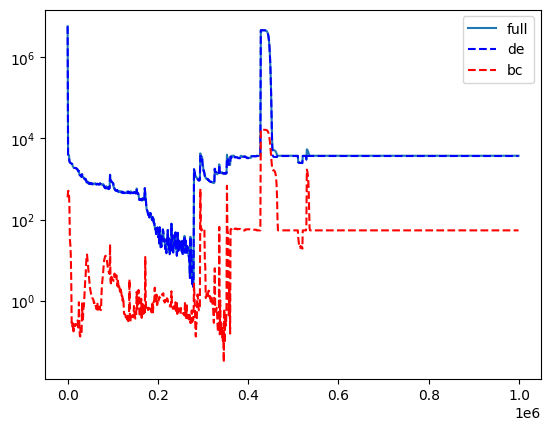

In [26]:
plt.figure()
plt.plot(iteration_vector,full_loss_vector,label = 'full')
plt.plot(iteration_vector,de_loss_vector,'b--',label = 'de')
plt.plot(iteration_vector,bc_loss_vector,'r--',label = 'bc')
plt.yscale('log')
plt.legend()

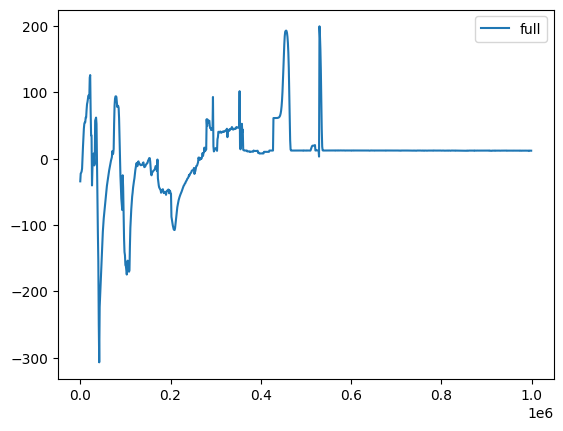

In [35]:
plt.figure()
plt.plot(iteration_vector,friction_prediction_vector,label = 'full')
plt.legend()

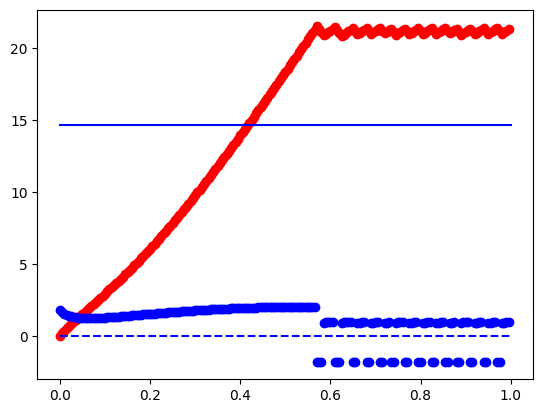

In [43]:
plt.figure()
t_data_domain = torch.linspace(0, 1, steps=1000).view(-1, 1)

with torch.no_grad():
    vel_prediction = PINN_optimal(t_data_domain).numpy()
    
t_data_domain.requires_grad = True
acc_prediction = df(PINN_optimal,t_data_domain,1).detach().numpy()

vel = sensor_data.detach().numpy()[:,1]*Vc
u = sensor_data.detach().numpy()[:,2]*Uc
acc_actual = (u/m - (50*(1-np.exp(-vel)) + 50/450*vel**2)/m)*Tc/Vc

plt.plot(t_interior.detach().numpy(),sensor_data.detach().numpy()[:,1]*Vc,'or-')
plt.plot(t_data_domain.detach().numpy(),vel_prediction*Vc,'b-')

plt.plot(t_data_domain.detach().numpy(),acc_prediction,'b--')
plt.plot(t_interior.detach().numpy(),acc_actual,'bo')

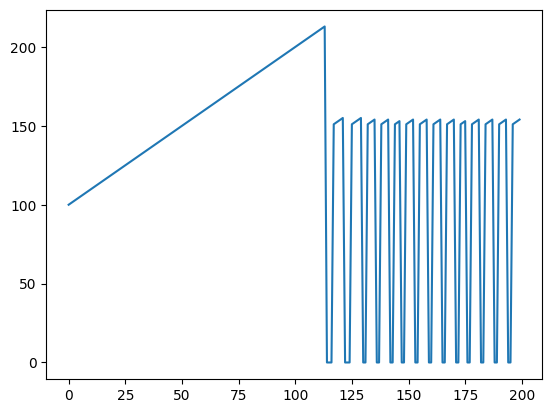

In [44]:
plt.figure()
plt.plot(u)

In [45]:
vel_data = sensor_data[:,1].view(-1,1)
u = sensor_data[:,2].view(-1,1)
de_loss = calc_de_loss(PINN_optimal,friction_optimal,t_collocation,u)
bc_loss = calc_bc_loss(PINN_optimal,friction_optimal,t_interior,vel_data)
#ic_loss = calc_ic_loss(PINN,0.0)

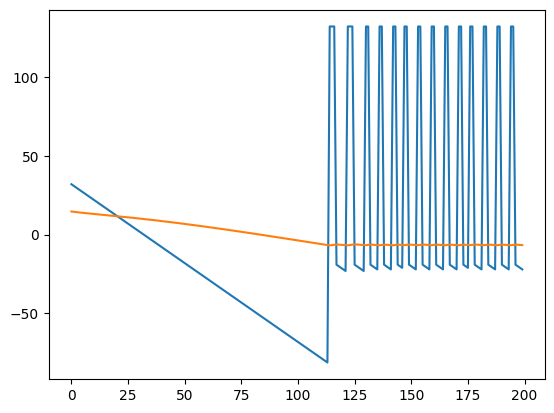

In [46]:
plt.figure()
plt.plot(de_loss.detach().numpy())
plt.plot(bc_loss.detach().numpy())

In [47]:
de_loss.pow(2).detach().numpy().mean()

3691.468

In [48]:
bc_loss.pow(2).detach().numpy().mean()

54.386795

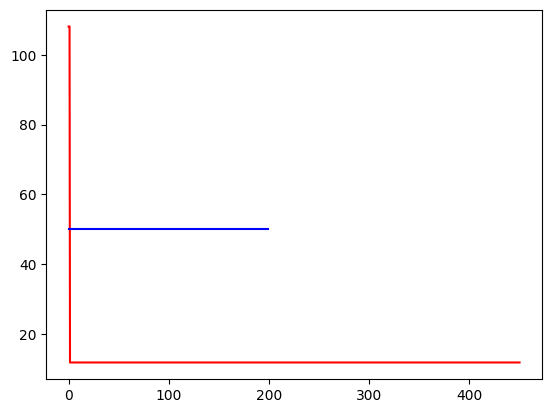

In [49]:
plt.figure()
# NOw interrogate the R approximator
t_data_domain = torch.linspace(0, 450, steps=1000).view(-1, 1)
with torch.no_grad():
    r_prediction = F_approx(t_data_domain).numpy()*50

plt.plot(t_data_domain,r_prediction,'r')
plt.plot(simulator.data['_time'],simulator.data['_tvp'][:,0],'b')